In [1]:
###############################################################################

from IPython.core.interactiveshell import InteractiveShell
import jupyternotify
import folium
import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import pandas as pd
from selenium import webdriver

InteractiveShell.ast_node_interactivity = "all"
get_ipython().register_magics(jupyternotify.JupyterNotifyMagics)
nest_asyncio.apply()

<IPython.core.display.Javascript object>

In [2]:
df = pd.read_parquet('data.parquet')

In [3]:
## Break down time information
df['Date (Month)'] = df.Date.dt.to_period('M')
df['Date (Week)'] = df.Date.dt.to_period('w')
df['Week Number'] = df.Date.dt.isocalendar().week.astype(int)
df['Month Number'] = df.Date.dt.month.astype(int)
df['Year'] = df.Date.dt.year.astype(int)

In [4]:
def top5():
    figure = pd.pivot_table(
        df,
        index='Date (Month)',
        columns='Category',
        values='Cents',
        aggfunc='sum',
        margins=True)
    figure = figure.T.sort_values('All', ascending=False).T
    figure = figure.drop(columns='All')
    figure = figure.drop(index='All')

    ## Change units to Millions of DOLLARS
    figure = figure/100/10**6

    ## Select top 4 categories
    figure = figure.iloc[:,:4]

    figure.plot(kind='line', figsize=(10,3))
    plt.title('Total Sales by Month (Top 4 Categories)')
    plt.ylabel('Millions of Dollars')
    plt.xlabel('')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05,1));


def map_proportion():
    figure5 = pd.pivot_table(
        df,
        index='County',
        columns='Category',
        values='Cents',
        aggfunc='sum',
        margins=True,
    )

    figure5.head()

    ## Make feature
    ratio = '\nProportion Whiskey\n(Among Vodka and Whiskey)'
    figure5['All'] = figure5.Whiskey + figure5.Vodka
    figure5[ratio] = figure5.Whiskey/figure5.All

    ## Find average Long-Lat for each county (weighted by # purchases)
    figure5_location = pd.pivot_table(
        df,
        index='County',
        values=['Longitude','Latitude'],
        aggfunc='mean')

    figure5 = figure5.merge(figure5_location, left_index=True, right_index=True)

    figure5.plot.scatter(
        x = 'Longitude',
        y = 'Latitude',
        c = ratio,
        s = 5000 * (figure5.All / figure5.All.max())**0.5, # Size (Area) by Total Expenditure
        alpha = 0.4,
        colormap = 'YlOrBr', #YlOrBr_r
        figsize=(10,5),
    );
    plt.title(
        'Proportion Spent on Whiskey Among Vodka and Whiskey Sales\n'
        '(Area Sized by Combined Expenditure)'
    );

def plot_item(item):
    figure = df[df.Item.str[:len(item)]==item.title()]
    figure = pd.pivot_table(
        figure,
        index='Date (Month)',
        values='Cents',
        aggfunc='sum',
    )
    figure = figure/10**6 # Dollars -> Millions

    figure.plot(kind='line', legend=None, figsize=(10,2))
    plt.title(f'Total Sales of {item}')
    plt.ylabel('Millions of Dollars')
    plt.xlabel('');
    plt.show();

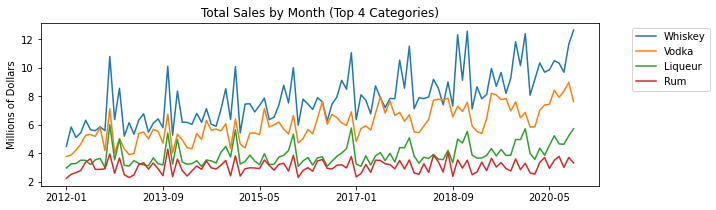

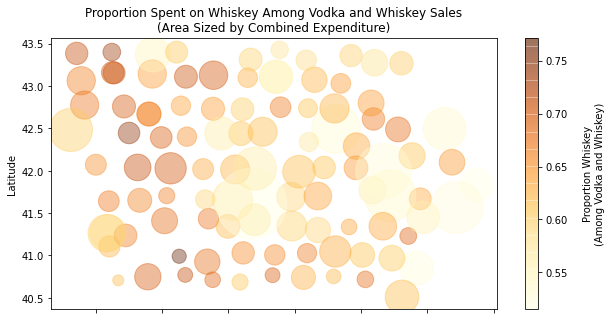

In [5]:
top5()
map_proportion() # See also 3-choropleth.ipynb

Text(0.5, 1.0, 'Average Sales by Week (Top 4 Categories)')

Text(0, 0.5, 'Millions of Dollars')

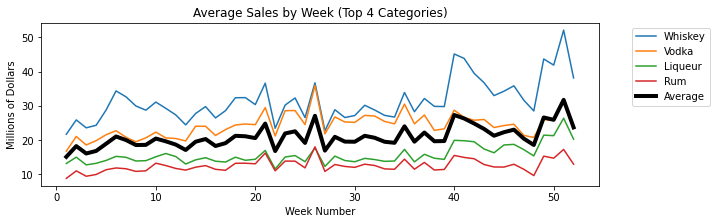

In [5]:
figure = pd.pivot_table(
    df[df.Year<=2019], # Year 2020 not complete
    index='Week Number',
    columns='Category',
    values='Cents',
    aggfunc='sum',
    margins=True,
)

## Divide by number of years to get average
figure = figure/len(df.Year.unique())

## Select top 4 categories
figure = figure.T.sort_values('All', ascending=False).T
figure = figure.drop(columns='All')
figure = figure.drop(index=['All',53])
figure = figure.iloc[:,:4]

## Change units to Millions of DOLLARS
figure = figure/100/10**6

## Correct for 5% sample
# figure = figure*20 # <===== Do not include if using data.parquet

figure.plot(kind='line', figsize=(10,3))
# figure.mean(axis=1).plot(kind='line', c='k', linewidth=4, label='Average')
plt.title('Average Sales by Week (Top 4 Categories)')
plt.ylabel('Millions of Dollars')
plt.legend(loc='upper left', bbox_to_anchor=(1.05,1));

figure = pd.pivot_table(
    df, # Include year 2020
    index='Week Number',
    values='Cents',
    columns='Year',
    aggfunc='sum',
).iloc[:-1] # Drop week 53

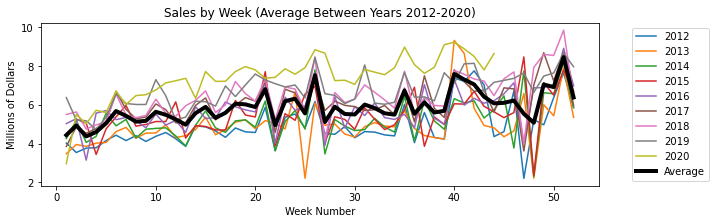

In [6]:
figure = pd.pivot_table(
    df, # Include year 2020
    index='Week Number',
    values='Cents',
    columns='Year',
    aggfunc='sum',
).iloc[:-1] # Drop week 53

## Change units to Millions of DOLLARS
figure = figure/100/10**6

## Correct for 5% sample
# figure = figure*20 # <===== Do not include if using data.parquet

figure.plot(kind='line', figsize=(10,3))
figure.mean(axis=1).plot(kind='line', c='k', linewidth=4, label='Average')

plt.title('Sales by Week (Average Between Years 2012-2020)')
plt.ylabel('Millions of Dollars')
plt.legend(loc='upper left', bbox_to_anchor=(1.05,1));

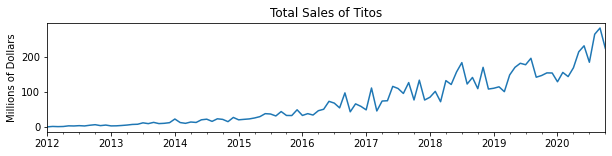

CPU times: user 9.86 s, sys: 6.34 s, total: 16.2 s
Wall time: 17.4 s


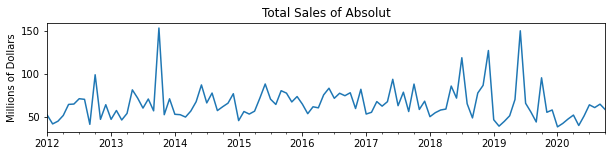

CPU times: user 9.34 s, sys: 4.75 s, total: 14.1 s
Wall time: 15.8 s


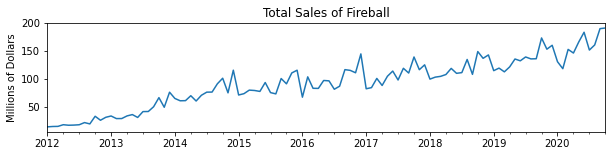

CPU times: user 9.29 s, sys: 4.48 s, total: 13.8 s
Wall time: 15.2 s


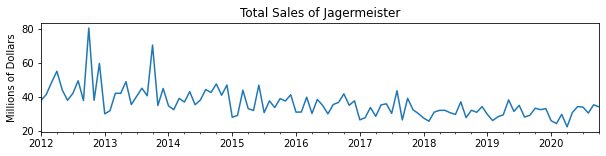

CPU times: user 9.2 s, sys: 2.95 s, total: 12.1 s
Wall time: 12.9 s


In [6]:
%time plot_item('Titos')
%time plot_item('Absolut')
%time plot_item('Fireball')
%time plot_item('Jagermeister')

# Graph of sales history for 652 product lines

In [7]:
###############################################################################
lines = [
    'number', 'hendricks', 'firefly', 'violette', 'hakushu', 'bowman', 'chili',
    'harper', 'stoke', 'mortlach', 'handmade', 'carolans', 'times', 'clynes',
    'leguas', 'hibiki', 'tarantula', 'horse', 'strawberries', 'weller',
    'glazed', 'cupcake', 'pearl', 'blast', 'winkle', 'compass', 'bols',
    'lasanta', 'wisconsin', 'mt', 'iowish', 'relska', 'caravella', 'tyrconnell',
    'liter', 'milagro', 'lucy', 'abuelo', 'angostura', 'garioch', 'lunazul',
    'cody', 'nocello', 'stuff', 'hyde', 'chivas', 'clearheart', 'twin',
    'grapevine', 'traditional', 'pact', 'knob', 'float', 'applik', 'clase',
    'razz', 'wears', 'cork', 'leroux', 'yeto', 'sinatra', 'penthouse', 'love',
    'sorbet', 'gluten', 'climax', 'appleberry', 'sugarland', 'tn', 'bowmore',
    'organics', 'pierre', 'hpnotiq', 'jeremiah', 'pike', 'juan', 'privilege',
    'tx', 'bozal', 'frost', 'germain', 'tgif', 'shortcake', 'dress', 'azunia',
    'ella', 'hart', 'sbr', 'banks', 'malibu', 'olmeca', 'combier', 'nadurra',
    'fitzgerald', 'sangrita', 'distiller', 'expresiones', 'stag', 'door', 'fee',
    'figenza', 'jones', 'indian', 'riva', 'mentholmint', 'penderyn', 'zero',
    'hiram', 'paradis', 'wrap', 'sapphire', 'lbl', 'finlandia', 'dual', 'dulce',
    'oath', 'winston', 'haus', 'tippy', 'infused', 'free', 'absolut', 'yb',
    'yell', 'luksusowa', 'ronrico', 'book', 'spicebox', 'talisker', 'chair',
    'bliss', 'letherbee', 'chopin', 'brugal', 'eduardo', 'titos', 'recipe',
    'sauza', 'kahlua', 'hunter', 'tullamore', 'envy', 'spell', 'stolichnaya',
    'clyde', 'castillo', 'blossom', 'capel', 'after', 'barbancourt', 'irishman',
    'hayden', 'dewars', 'seagram', 'clynelish', 'fasszination', 'badel', 'wave',
    'ramon', 'kauai', 'derby', 'dubliner', 'nacho', 'sours', 'ambler', 'daviess',
    'boodles', 'polish', 'siete', 'blackberries', 'cruzan', 'weed', 'ciroc',
    'regency', 'conciere', 'tim', 'david', 'coastal', 'los', 'guava', 'absente',
    'scotia', 'nights', 'laphroaig', 'calypso', 'brendans', 'haymans', 'zang',
    'loco', 'pinnacle', 'casey', 'repeal', 'crushed', 'kirk', 'gingers', 'viniq',
    'arango', 'stagg', 'jameson', 'mothers', 'glenkinchie', 'sweeney', 'ila',
    'norte', 'giffard', 'caskmates', 'writers', 'deleon', 'you', 'elit',
    'knappogue', 'elijah', 'ancnoc', 'makers', 'quarter', 'laing', 'smith',
    'benromach', 'fender', 'mangoes', 'jay', 'godiva', 'massenez', 'zarco',
    'tooters', 'package', 'calico', 'twenty', 'thatchers', 'oddka', 'nelson',
    'chartreuse', 'paddy', 'marshmallow', 'smirnoff', 'judge', 'duke', 'toschi',
    'fleischmanns', 'hornitos', 'redbreast', 'junior', 'tf', 'hawkeye', 'cana',
    'bros', 'filibuster', 'mignon', 'beluga', 'committee', 'calumet', 'ursus',
    'redemption', 'morin', 'glenmorangie', 'beefeater', 'revel', 'peligroso',
    'appalachian', 'mckenna', 'forester', 'shellback', 'fireball', 'clasico',
    'mr', 'kessler', 'all', 'cantera', 'barenjager', 'deanston', 'cherries',
    'sister', 'roger', 'piehole', 'blackheart', 'twist', 'creamer', 'rabbit',
    'pueblo', 'state', 'julio', 'martell', 'malted', 'dickel', 'northern',
    'buttershots', 'glendullan', 'lucid', 'cabrito', 'blantons', 'own', 'papas',
    'tgifridays', 'gjergj', 'cuervo', 'dubouchett', 'ultimate', 'shipper',
    'legendary', 'tesoro', 'charter', 'suze', 'glenfiddich', 'brooks', 'razberi',
    'seal', 'centinela', 'bonnie', 'glenlivet', 'bastille', 'vals', 'belvedere',
    'dobel', 'kinky', 'rip', 'fat', 'pucker', 'bushmills', 'montezuma', 'fenice',
    'buchanan', 'amrita', 'ilegal', 'elmer', 'farm', 'forbidden', 'early',
    'tanqueray', 'aberfeldy', 'asbach', 'few', 'meukow', 'gionelli', 'horchata',
    'skol', 'pulteney', 'rumple', 'exotico', 'springbank', 'hunch', 'deep',
    'riegers', 'shady', 'trace', 'commemorative', 'lake', 'minze', 'kurayoshi',
    'hickory', 'gilbeys', 'adelaides', 'mahoney', 'peak', 'over', 'plymouth',
    'california', 'captain', 'adult', 'personal', 'juggs', 'gentlemen', 'popcorn',
    'rittenhouse', 'lagavulin', 'collins', 'liga', 'obtainium', 'hatozaki',
    'celtic', 'spot', 'johnson', 'camp', 'plume', 'alize', 'roca', 'nivel',
    'bourye', 'baja', 'berentzen', 'mediterranean', 'cow', 'windsor', 'dom',
    'eh', 'mcclelland', 'bulleit', 'chamucos', 'tinkermans', 'diplomatico',
    'rebel', 'menage', 'sorrento', 'cragganmore', 'eagle', 'bird', 'atomic',
    'ale', 'michael', 'amsterdam', 'jane', 'larceny', 'whistler', 'crater',
    'lord', 'scorpion', 'commanders', 'stara', 'yukon', 'time', 'ryan', 'antique',
    'rumhaven', 'ohranj', 'cabin', 'tgi', 'oban', 'vics', 'johnnie', 'oyo',
    'travis', 'luscious', 'avion', 'moletto', 'barcraft', 'nuestra', 'prickly',
    'bombay', 'hooters', 'ardbeg', 'glendronach', 'nuvo', 'loconut', 'nicholson',
    'mayalen', 'effen', 'frida', 'bush', 'cardhu', 'mccoy', 'minichatas', 'rain',
    'cincoro', 'variety', 'rts', 'baur', 'alberta', 'everclear', 'bernheim',
    'tortilla', 'amore', 'frappachata', 'peachtree', 'sierra', 'yellowstone',
    'bubble', 'whitetail', 'remus', 'dalwhinnie', 'zacapa', 'ornament',
    'midleton', 'bookers', 'henry', 'woodford', 'sljivovica', 'cerises', 'mayor',
    'apples', 'concord', 'paloma', 'rich', 'baileys', 'sourced', 'wedding',
    'dekuyper', 'dingle', 'zing', 'milk', 'popov', 'calvert', 'edradour', 'amrut',
    'oakheart', 'mathilde', 'cookie', 'spruce', 'kaiyo', 'negra', 'belles',
    'comisario', 'ryans', 'hamilton', 'valentino', 'ketel', 'lovers', 'mandrin',
    'fluffed', 'for', 'pallini', 'patch', 'at', 'replica', 'skenderbeu', 'forex',
    'mays', 'agavero', 'atlantico', 'herradura', 'evan', 'tapatio', 'craig',
    'oranges', 'crave', 'svedka', 'eoy', 'admiral', 'selected', 'smoked',
    'caliber', 'overholt', 'corzo', 'bakon', 'millet', 'bing', 'aalborg',
    'doublewood', 'torada', 'monte', 'eddy', 'uv', 'parrot', 'rumchata',
    'tramonto', 'loopy', 'taaka', 'orchard', 'pop', 'bayou', 'masson', 'blondies',
    'benchmark', 'cotton', 'rakija', 'galliano', 'salvadors', 'arrow',
    'margaritaville', 'holstein', 'trois', 'jimador', 'dt', 'roner', 'cazadores',
    'platte', 'morgan', 'fox', 'voli', 'kilbeggan', 'chila', 'hangar', 'sundae',
    'kahlo', 'whalers', 'face', 'orphan', 'olives', 'craft', 'ksbw', 'burnetts',
    'ypioca', 'crow', 'michters', 'buchanans', 'balvenie', 'patricks', 'shots',
    'barton', 'jose', 'muddler', 'benriach', 'ardmore', 'barcelo', 'tradicional',
    'takovo', 'rhetoric', 'thrones', 'mozart', 'chambord', 'schladerer', 'altos',
    'diggers', 'spout', 'kilchoman', 'rothman', 'jr', 'spanish', 'experience',
    'authentic', 'quinta', 'soledad', 'lazzaroni', 'chamisul', 'cavalli',
    'matusalem', 'powers', 'skinnygirl', 'juarez', 'gunpowder', 'opulent',
    'stirrings', 'mcgillicuddys', 'kiss', 'jeffersons', 'il', 'kru', 'parkers',
    'machetazo', 'falernum', 'courvoisier', 'cien', 'gordons', 'burst', 'mucha',
    'clement', 'jelly', 'dill', 'codigo', 'ivory', 'born', 'korbel', 'petal',
    'donut', 'glenfarclas', 'retail', 'reyka', 'generaciones', 'kuhl', 'dant',
    'singleton', 'trinidad', 'alban', 'grouse', 'kraken', 'aloha', 'ezra', 'goose',
    'states', 'trimbach', 'jerry', 'cove', 'ferrand', 'walkers']

652

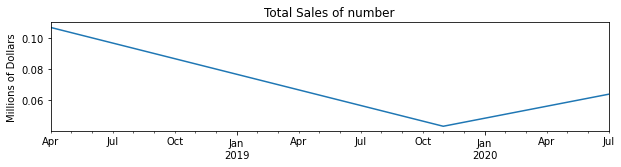

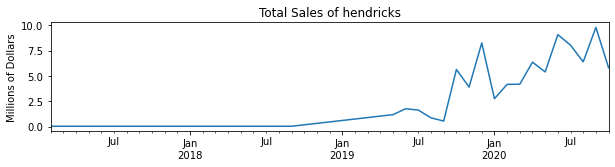

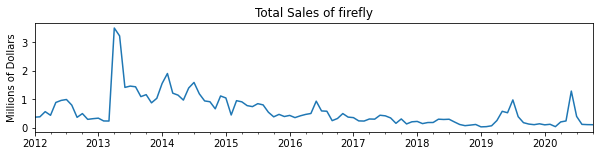

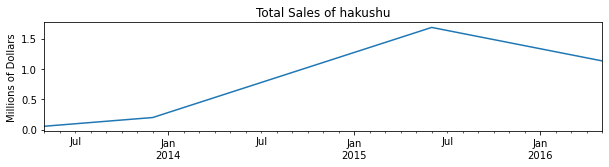

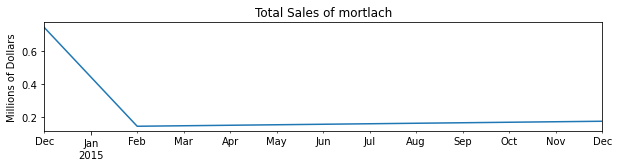

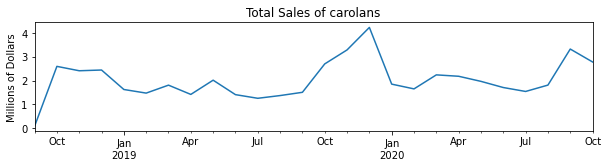

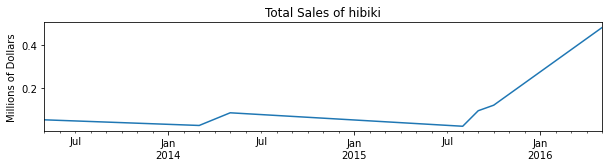

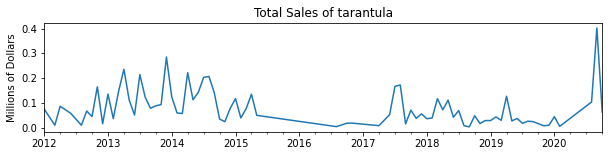

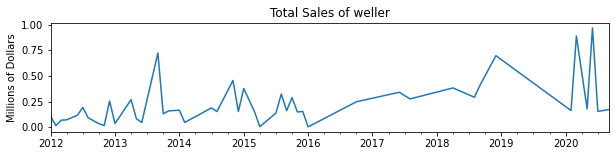

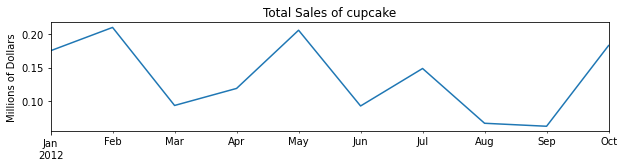

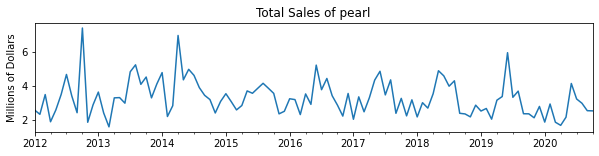

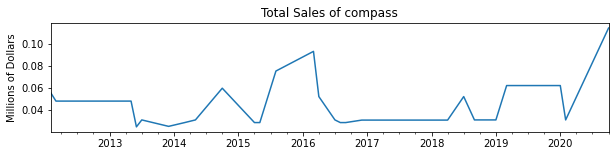

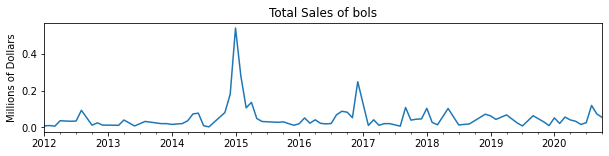

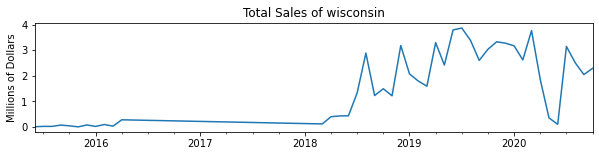

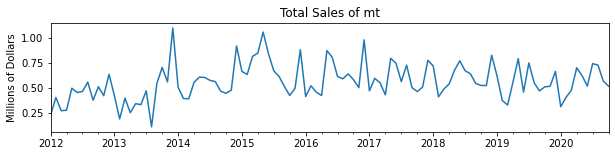

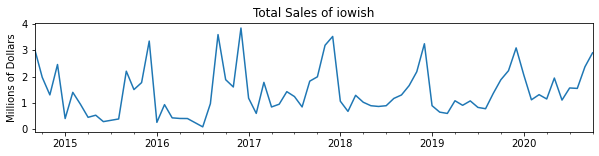

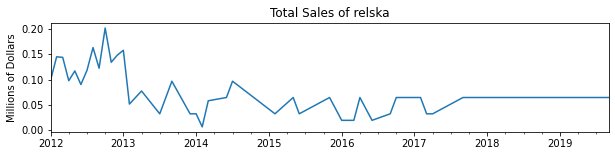

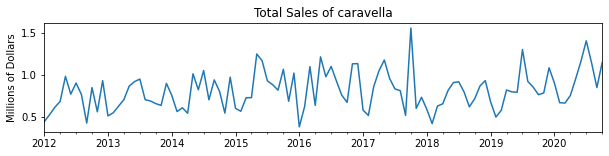

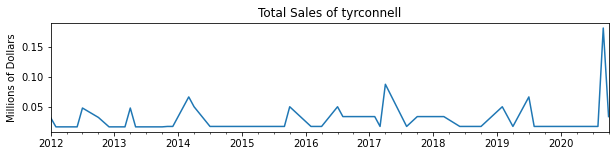

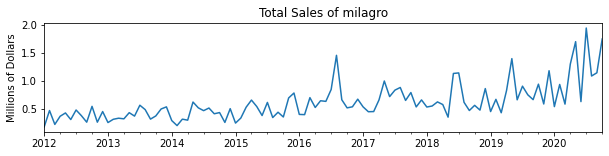

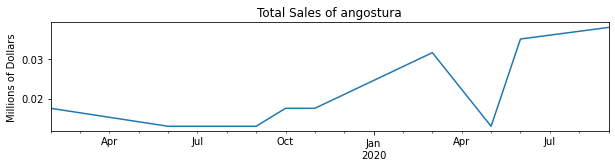

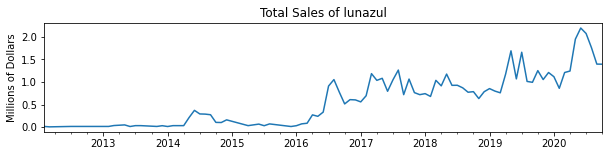

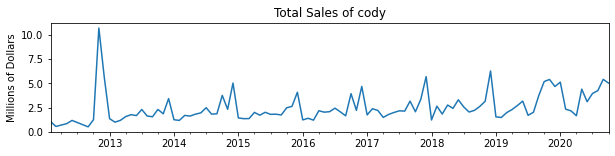

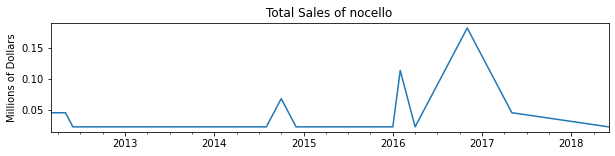

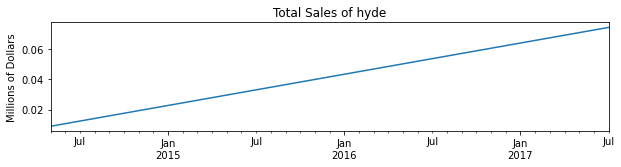

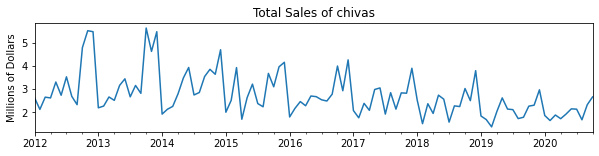

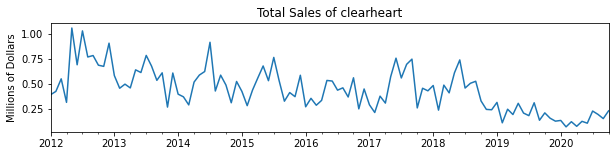

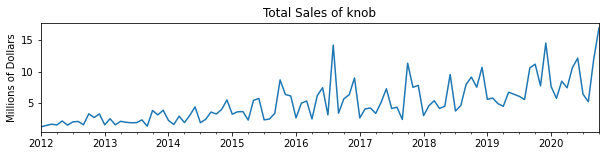

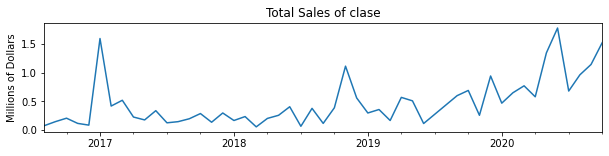

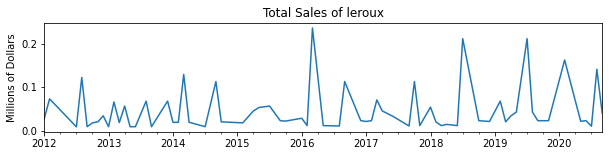

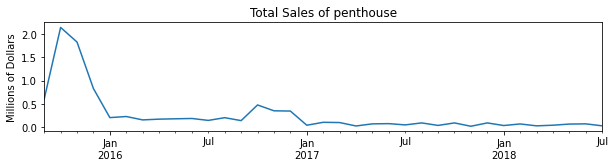

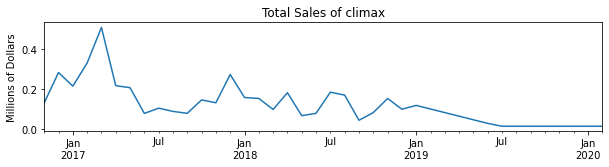

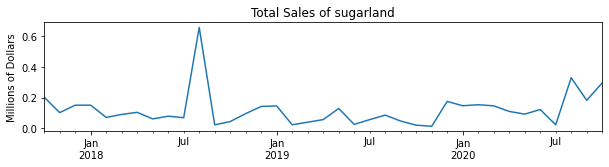

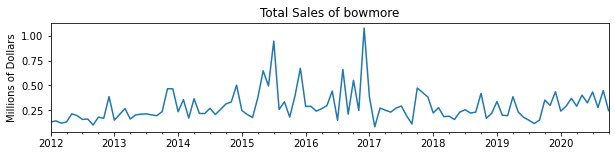

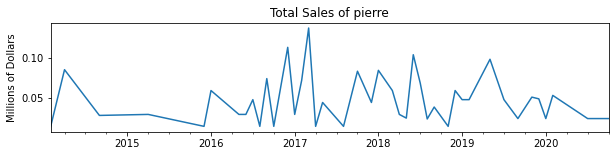

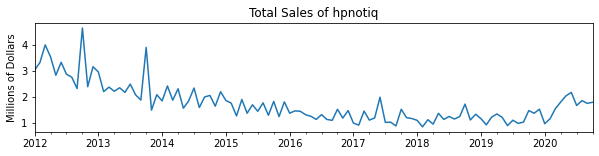

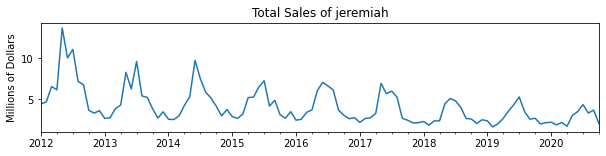

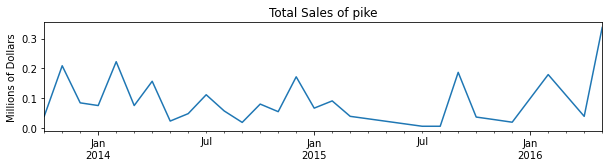

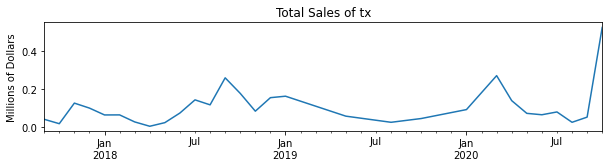

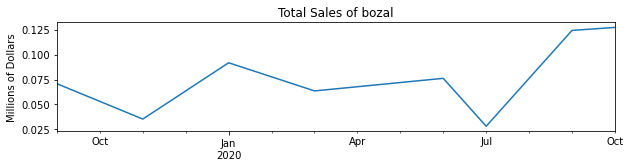

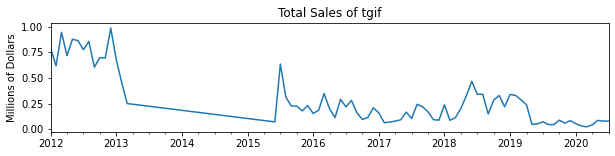

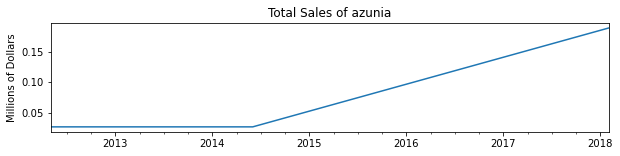

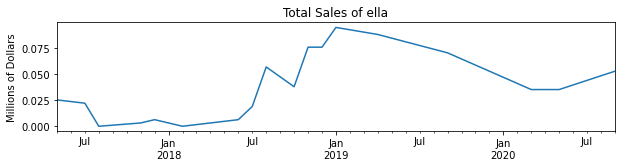

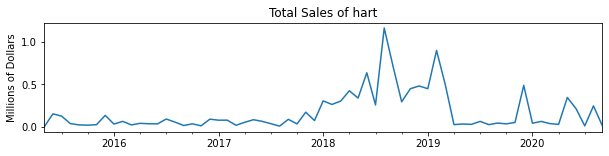

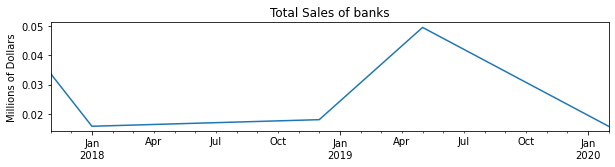

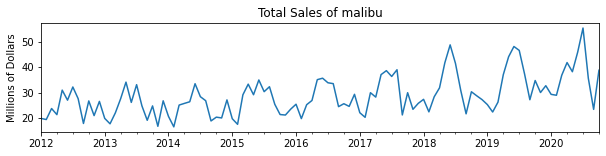

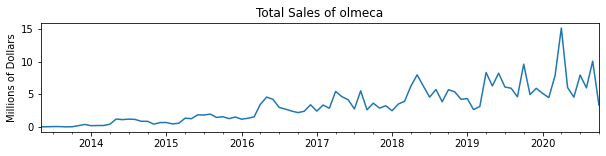

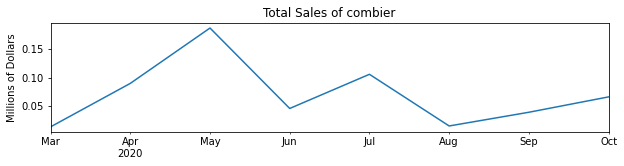

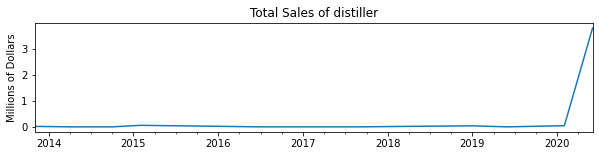

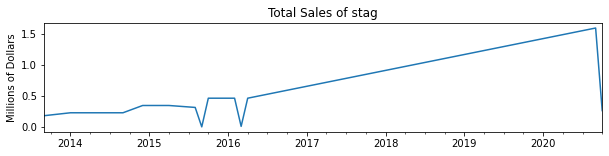

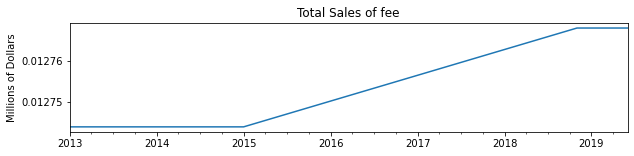

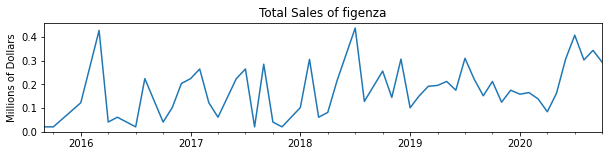

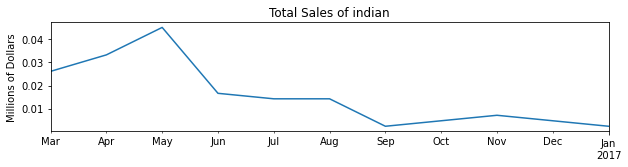

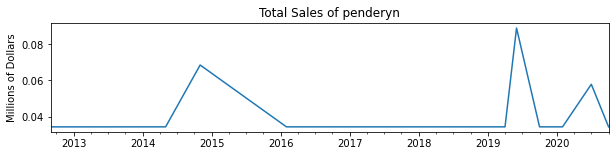

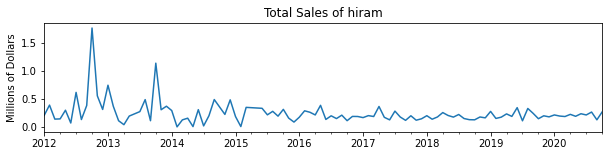

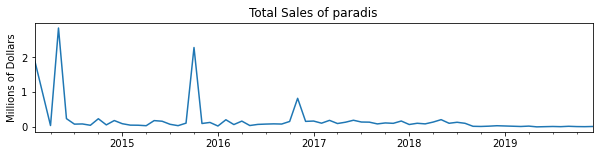

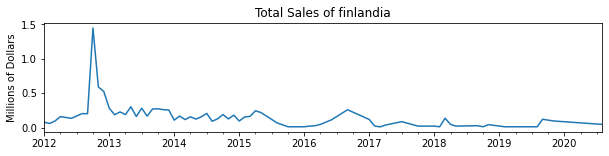

/Users/sunderland20a/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1136: UserWarning: Attempting to set identical left == right == 600.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


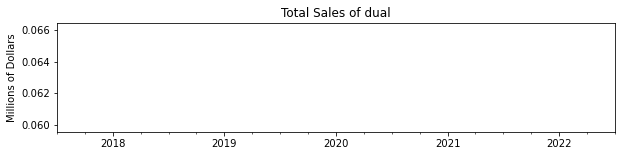

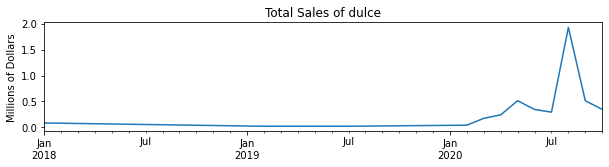

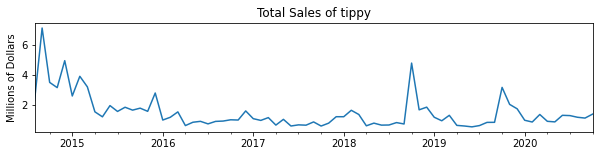

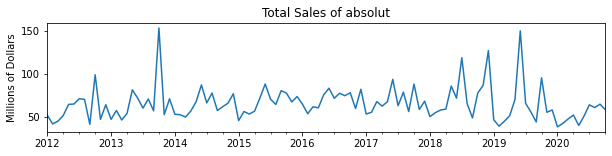

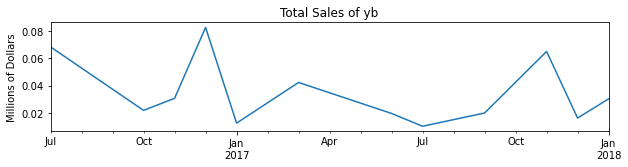

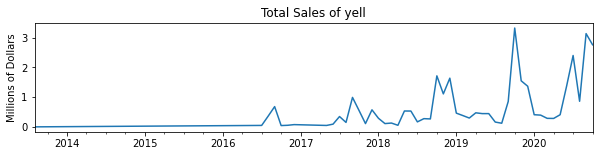

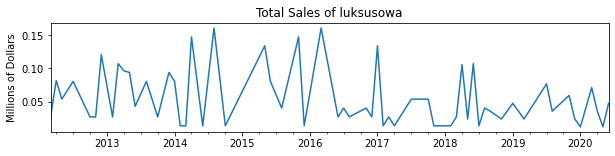

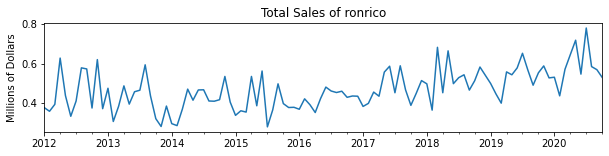

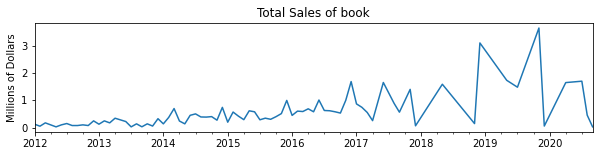

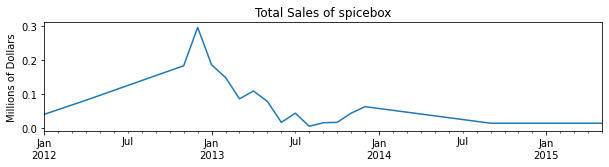

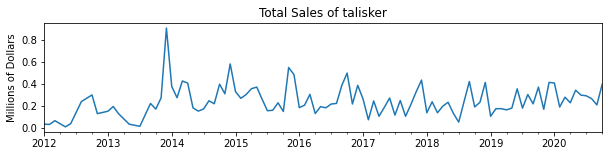

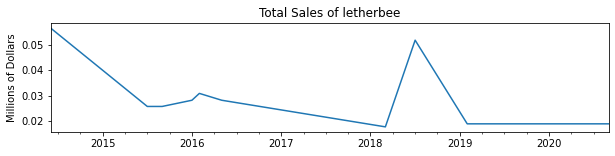

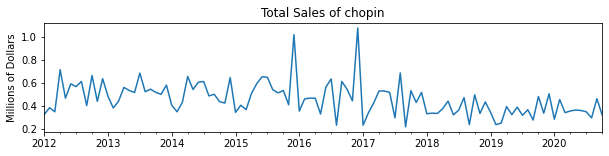

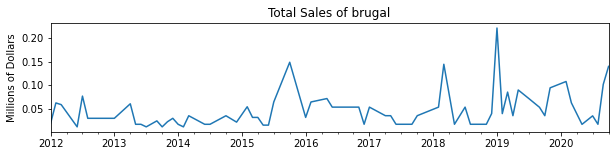

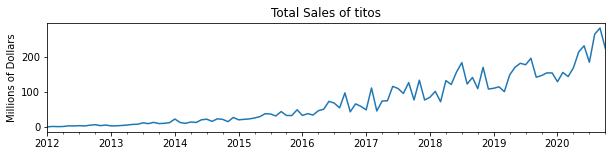

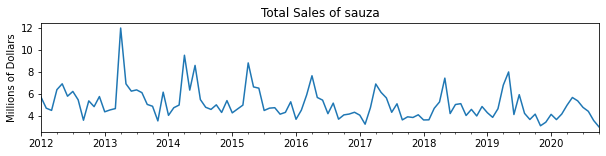

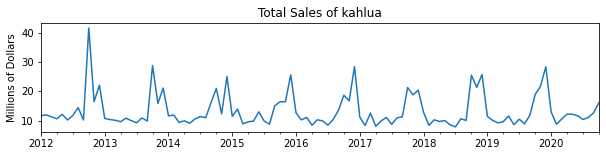

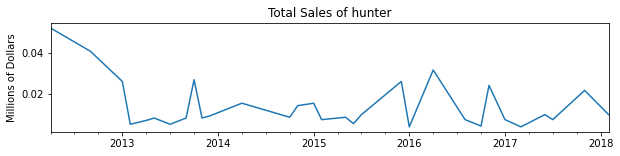

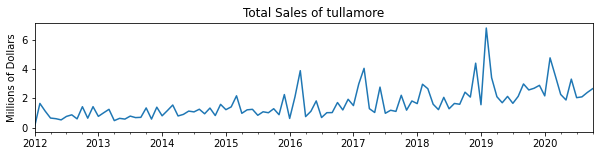

/Users/sunderland20a/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1136: UserWarning: Attempting to set identical left == right == 542.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


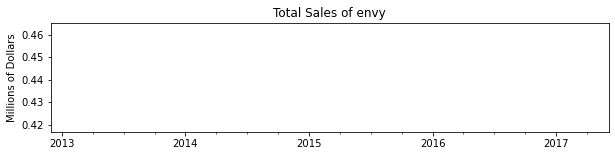

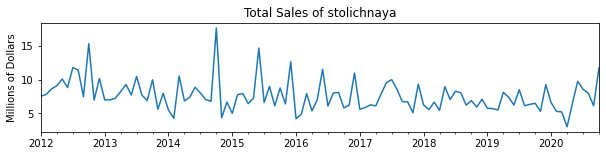

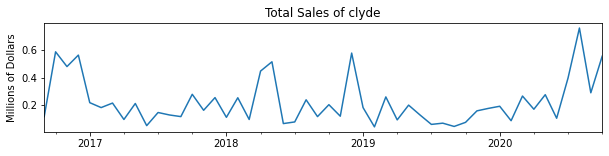

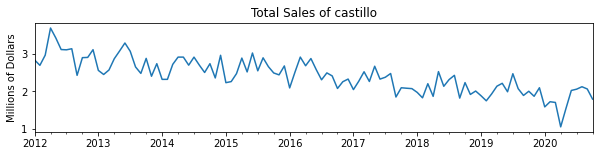

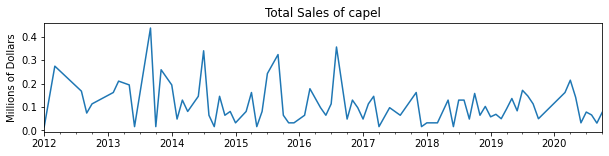

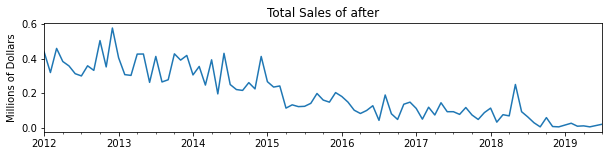

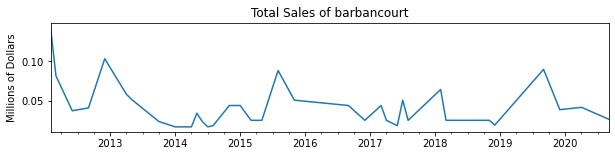

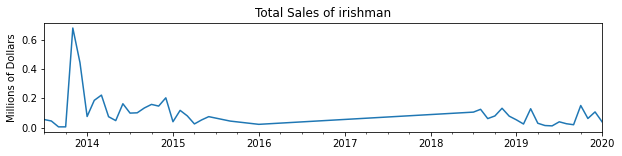

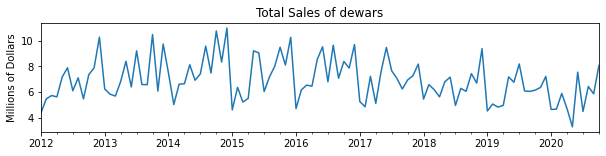

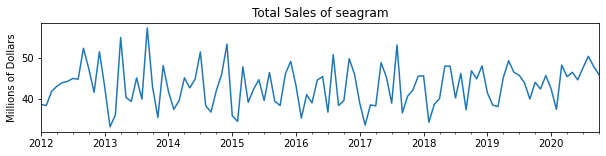

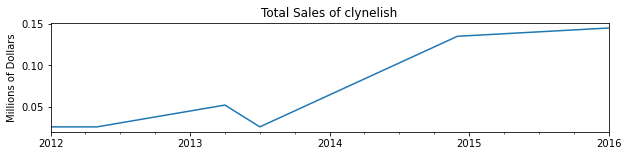

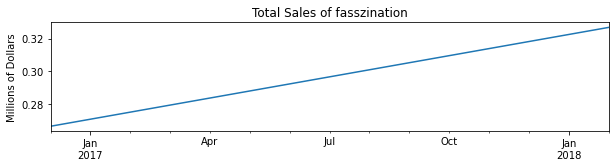

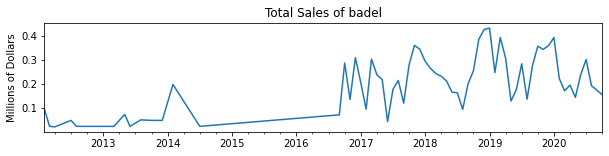

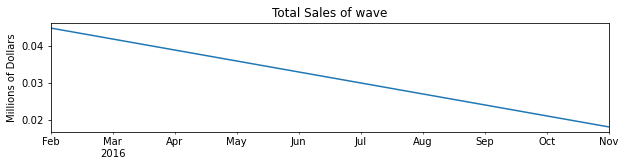

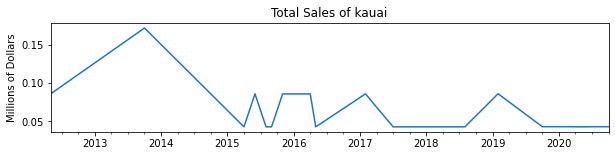

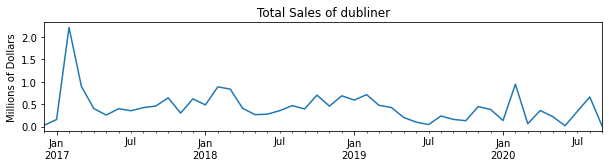

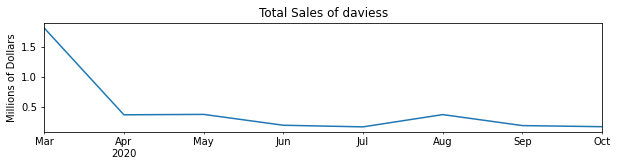

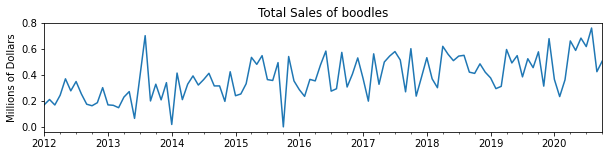

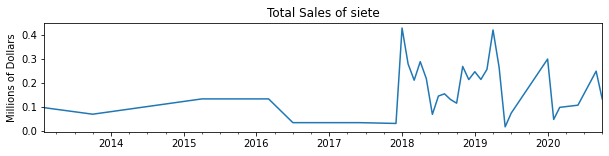

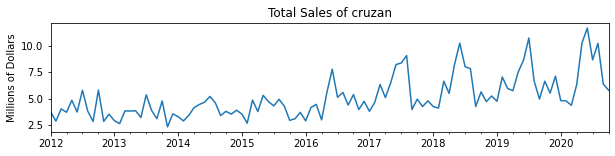

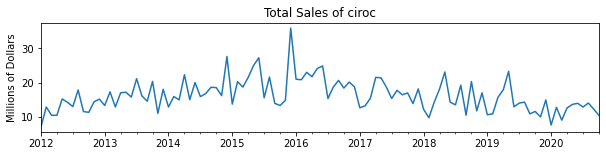

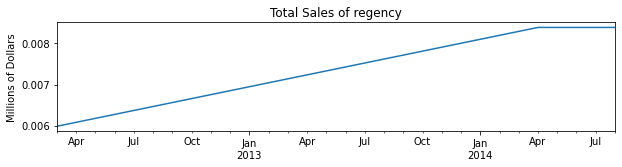

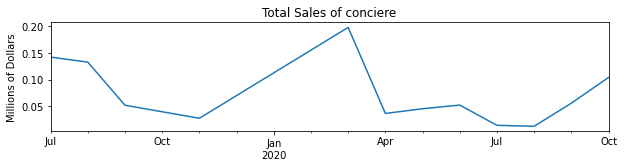

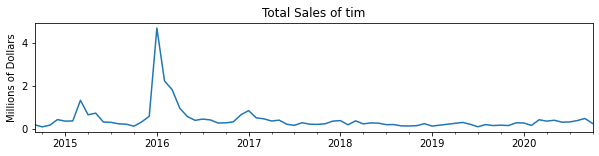

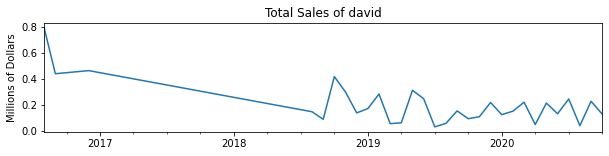

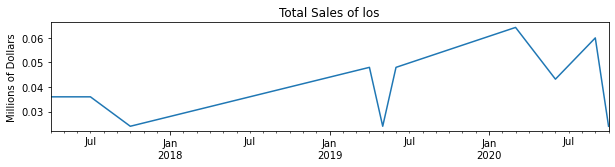

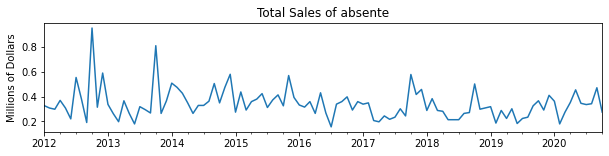

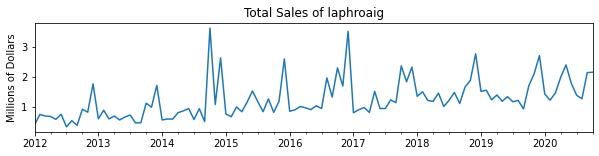

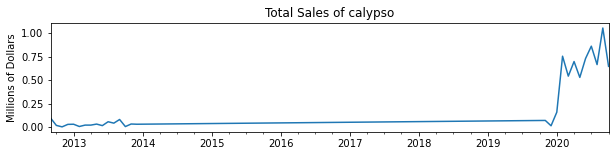

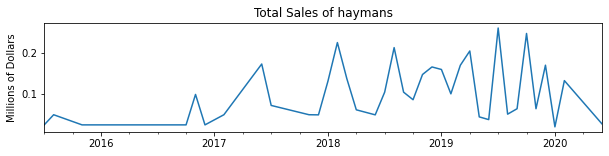

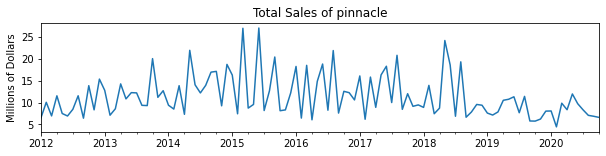

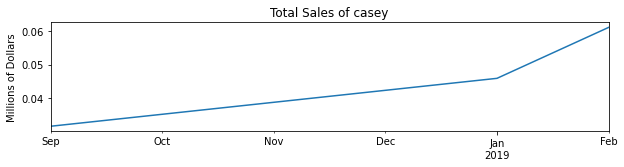

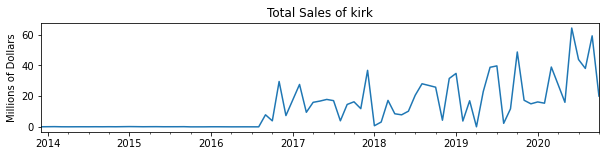

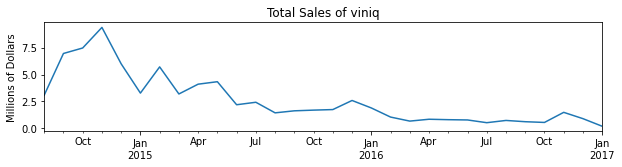

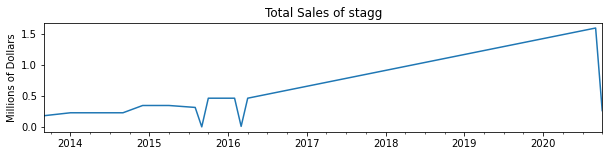

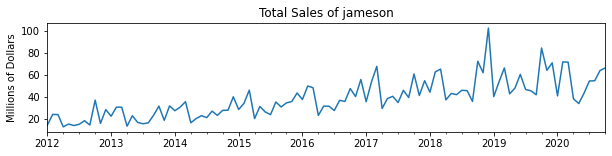

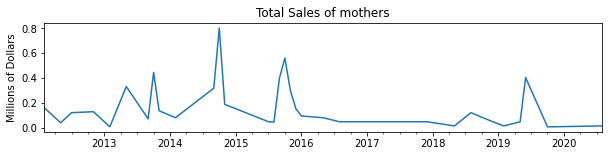

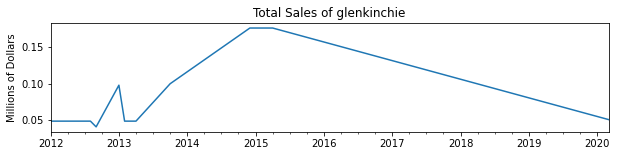

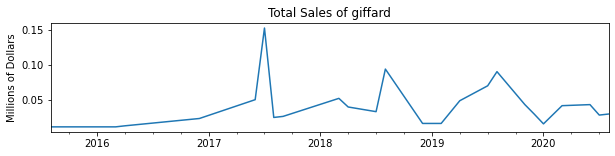

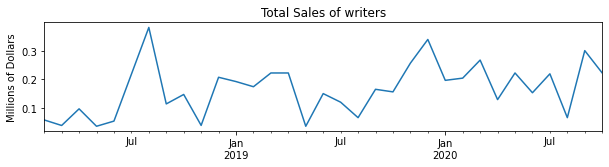

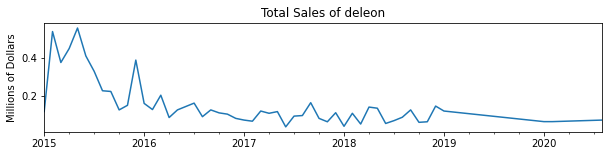

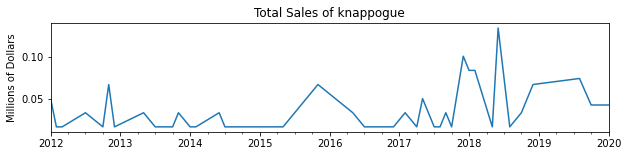

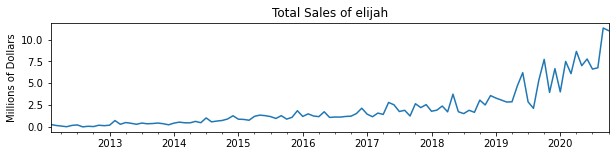

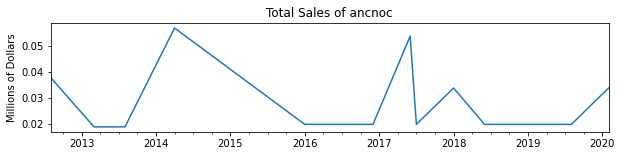

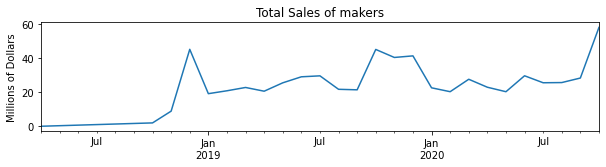

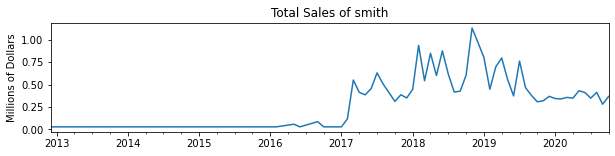

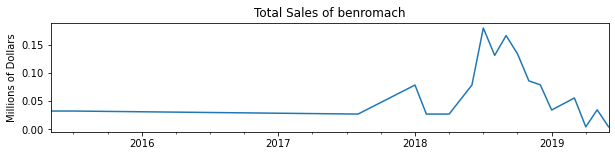

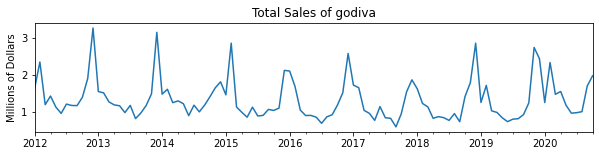

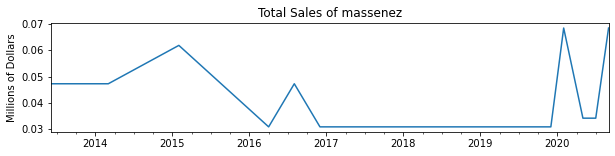

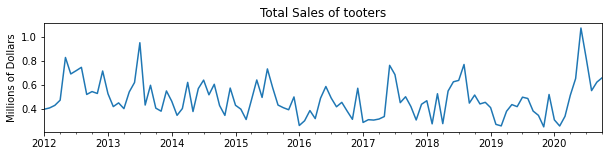

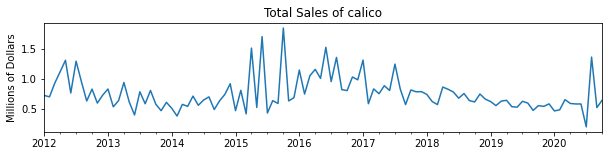

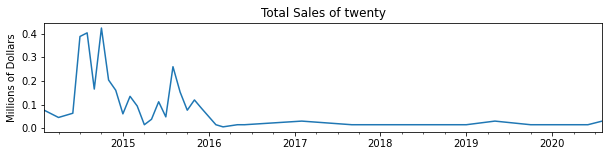

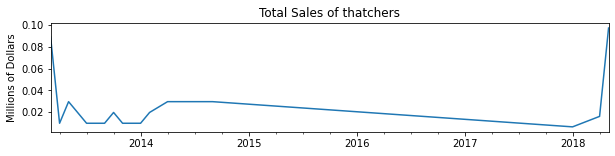

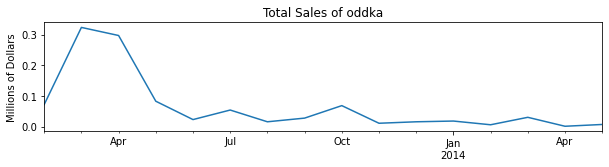

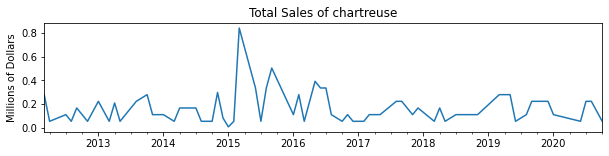

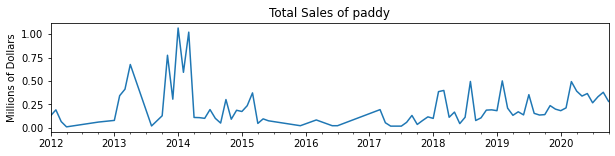

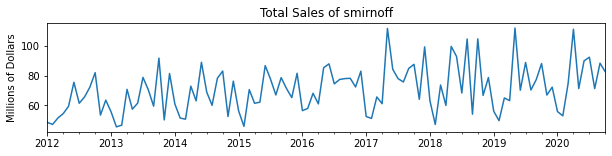

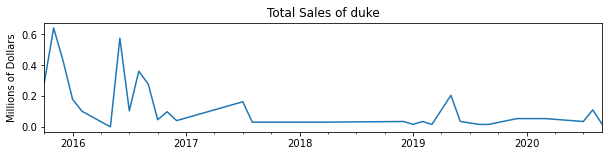

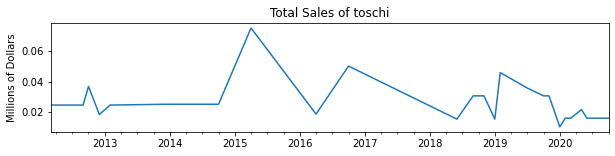

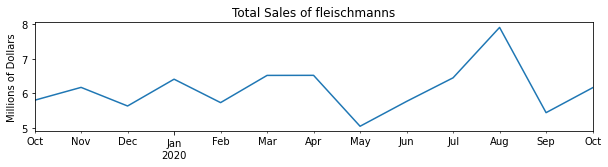

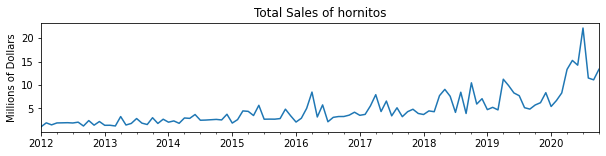

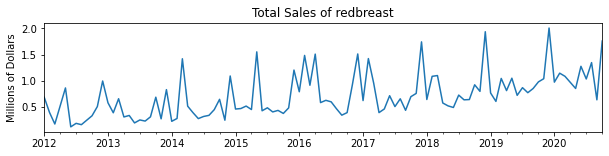

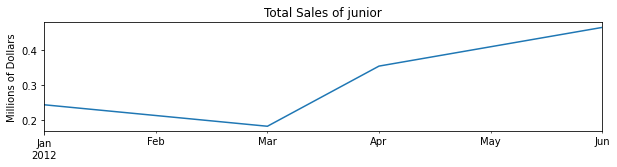

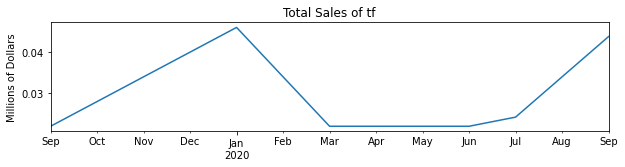

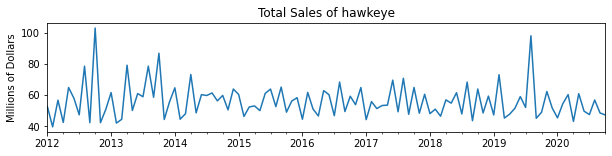

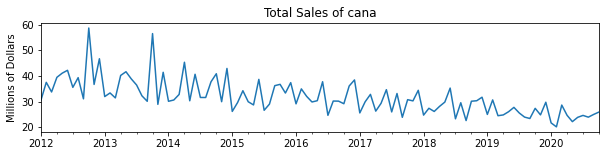

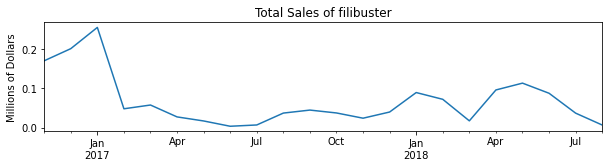

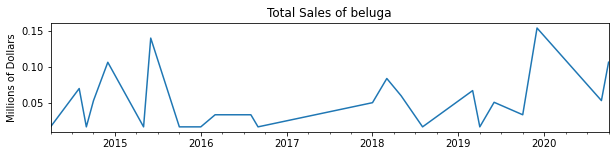

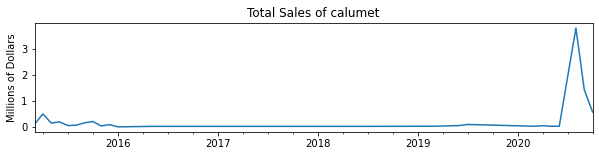

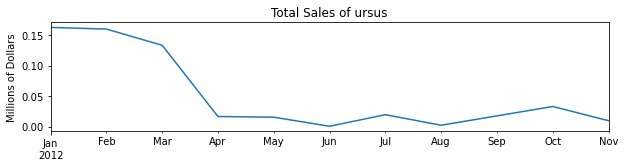

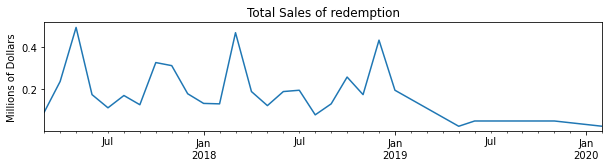

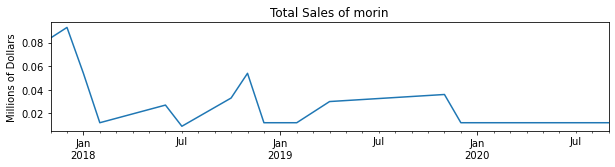

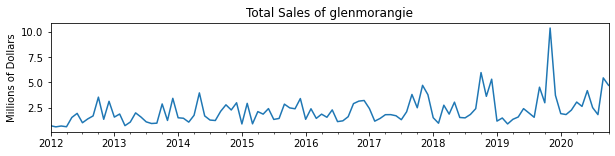

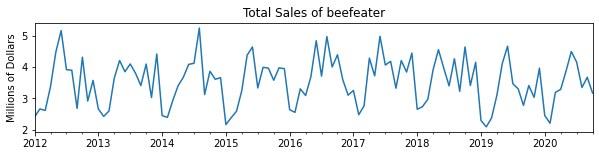

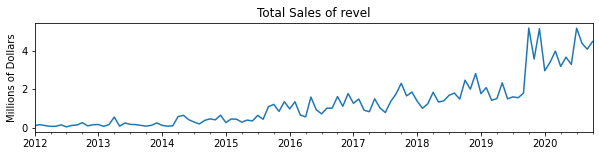

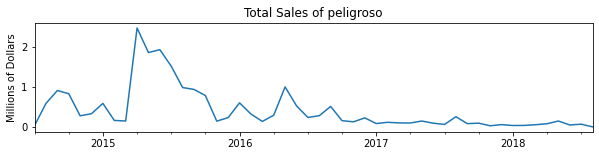

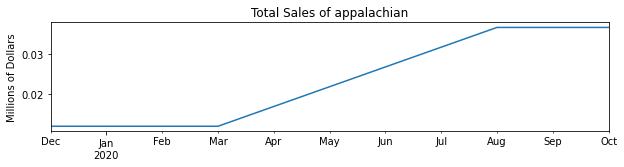

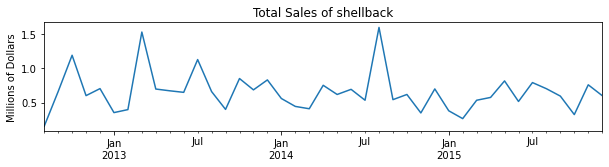

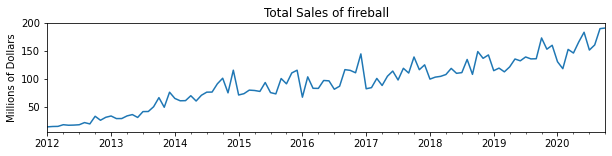

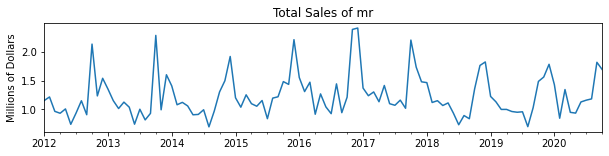

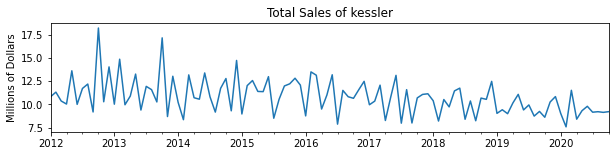

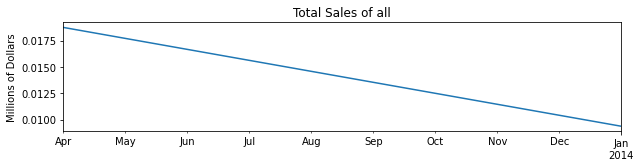

/Users/sunderland20a/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1136: UserWarning: Attempting to set identical left == right == 589.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


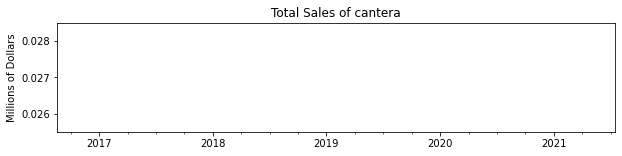

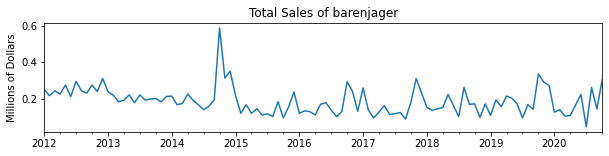

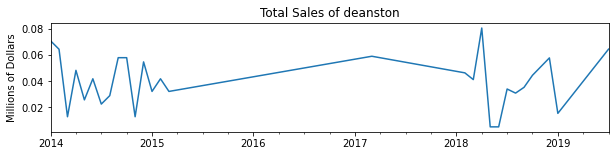

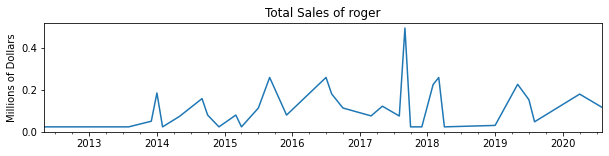

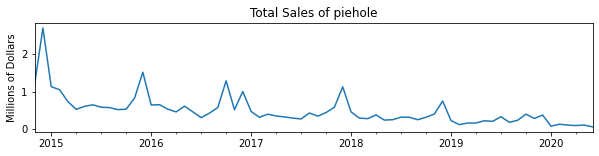

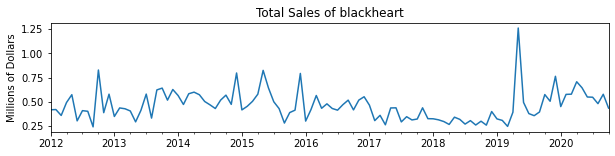

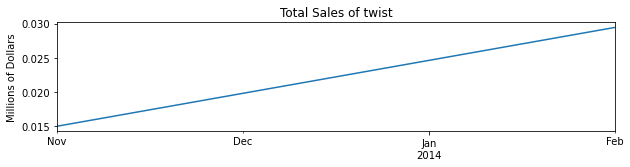

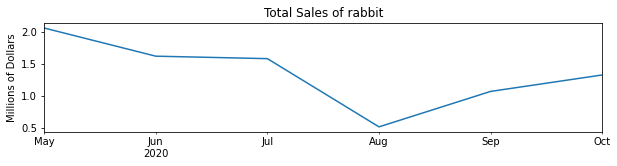

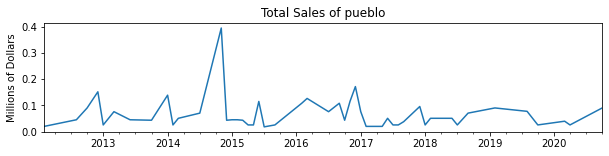

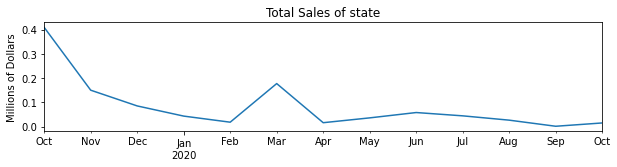

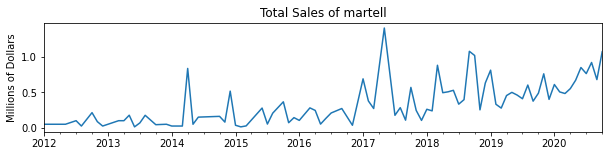

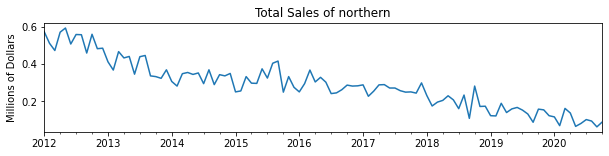

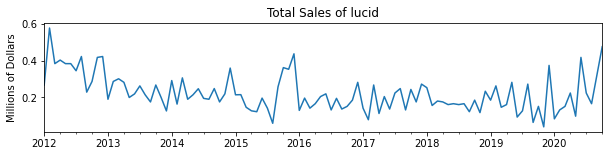

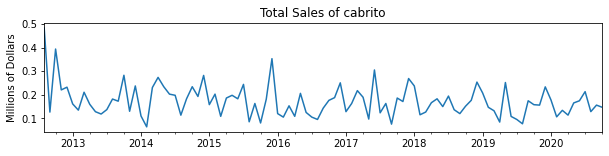

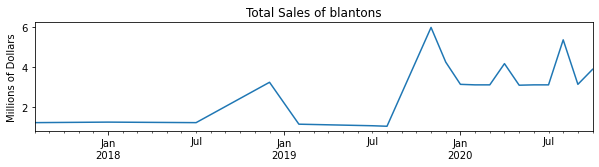

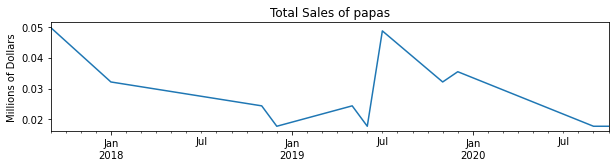

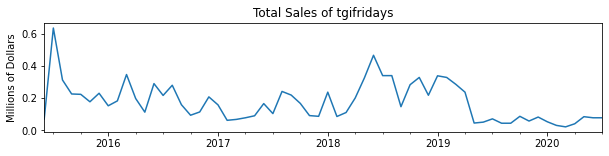

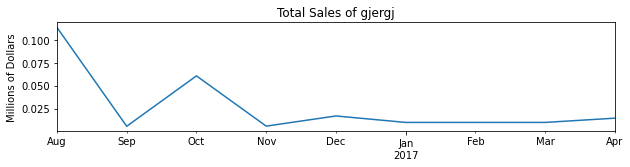

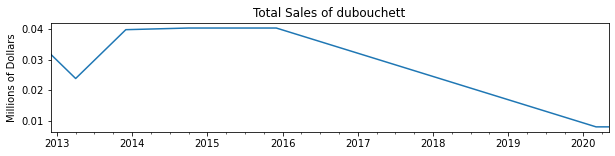

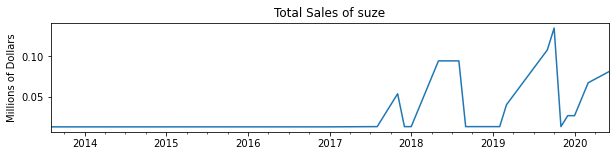

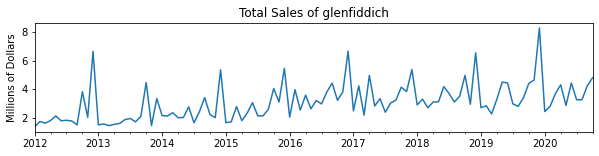

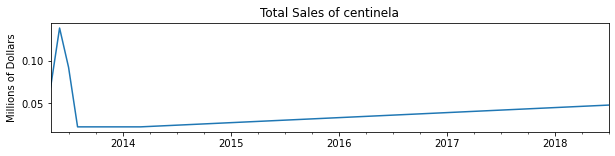

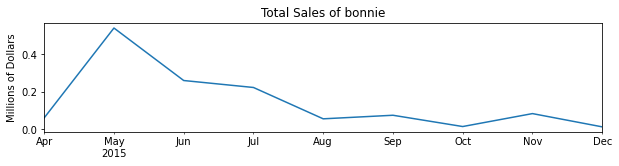

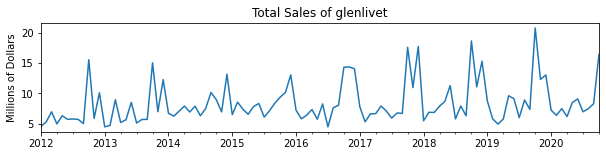

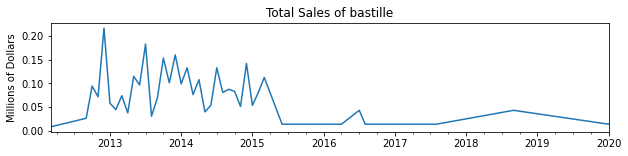

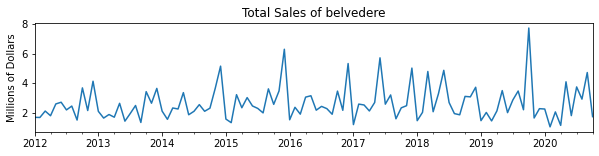

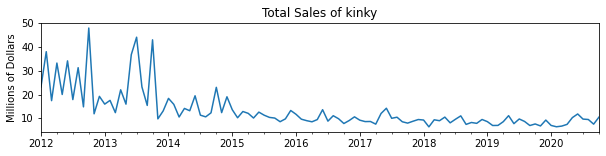

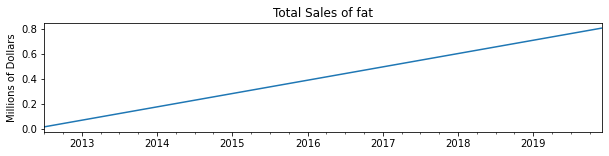

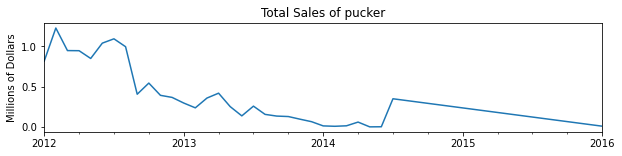

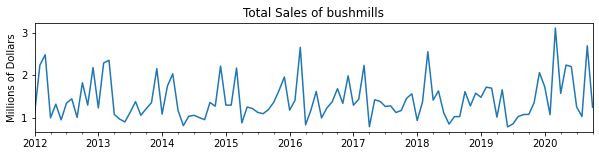

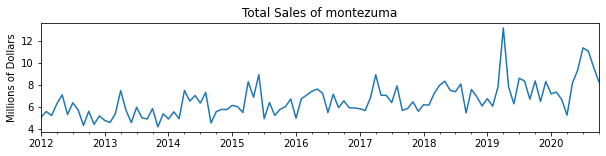

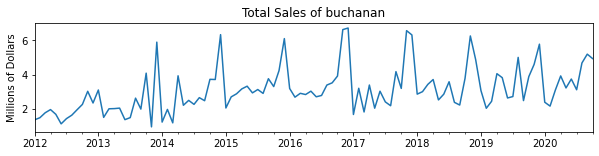

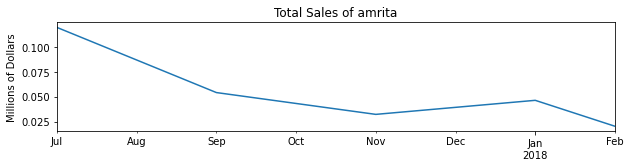

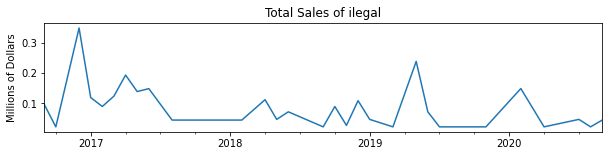

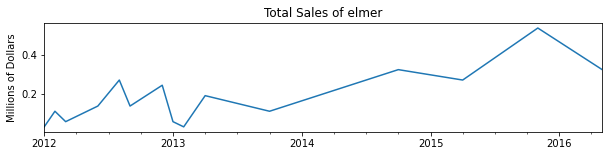

/Users/sunderland20a/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1136: UserWarning: Attempting to set identical left == right == 542.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


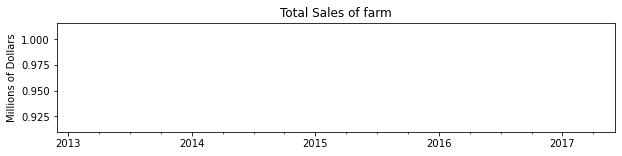

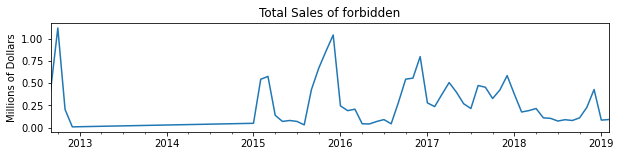

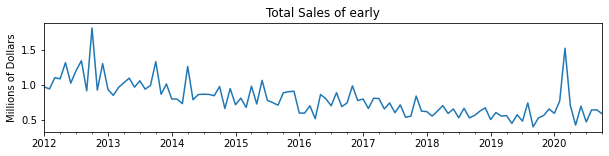

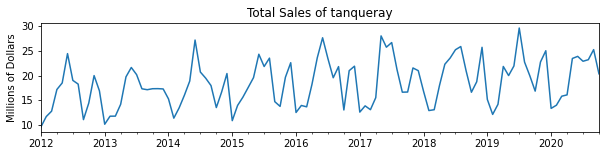

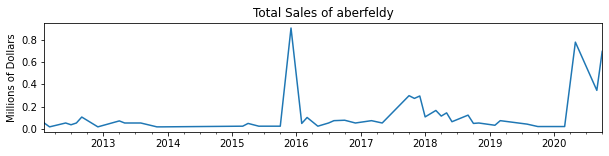

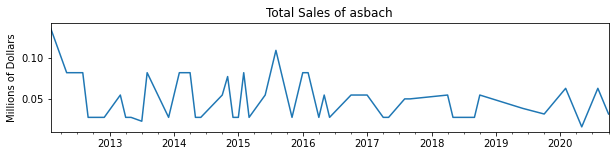

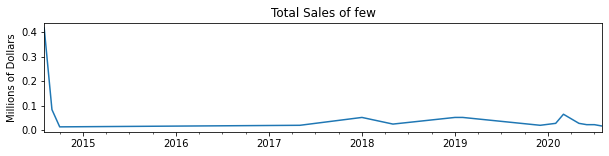

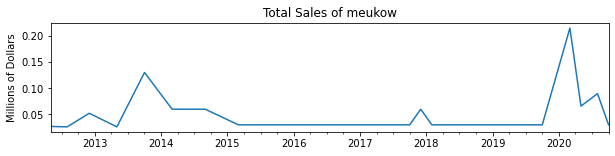

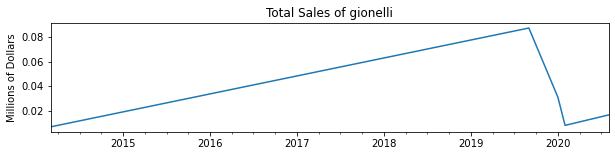

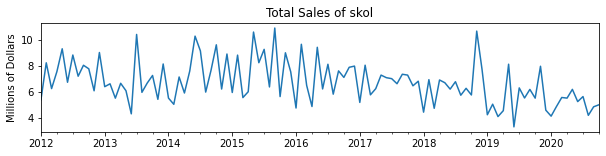

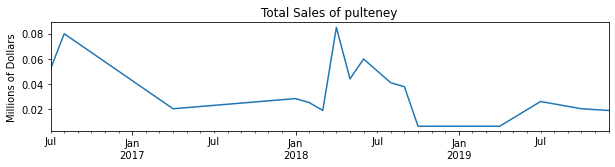

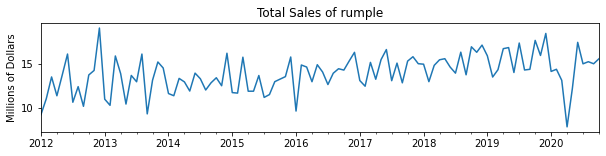

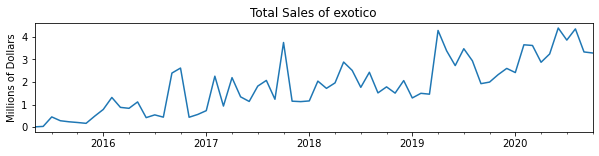

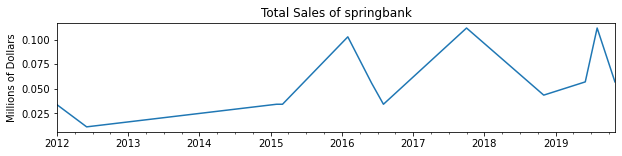

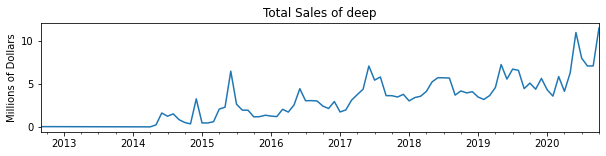

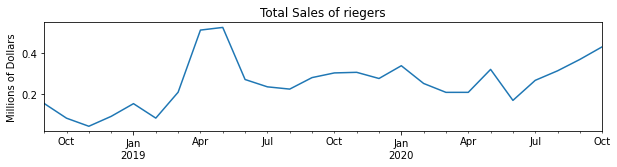

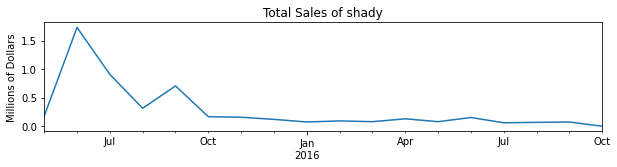

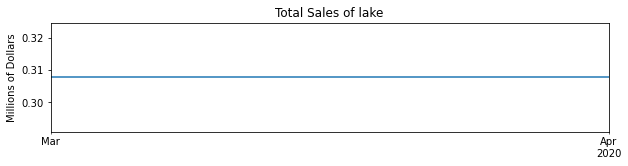

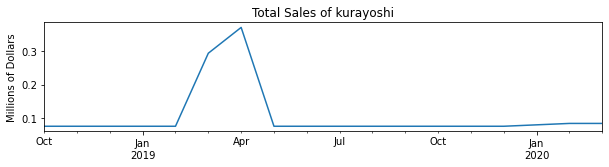

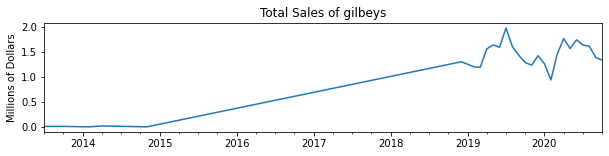

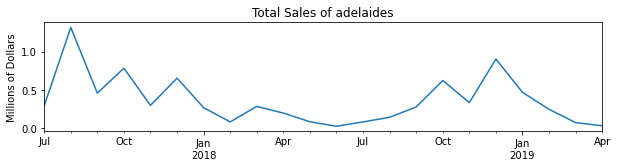

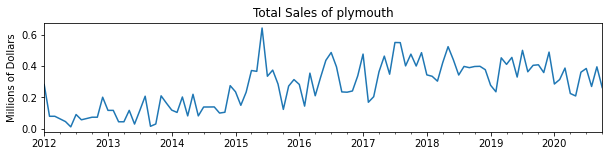

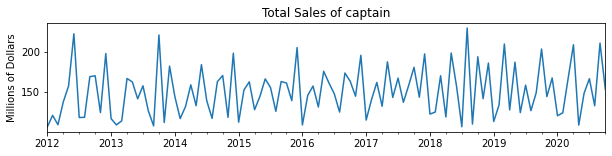

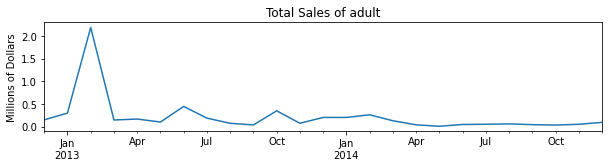

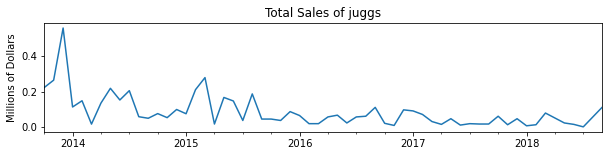

/Users/sunderland20a/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1136: UserWarning: Attempting to set identical left == right == 554.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


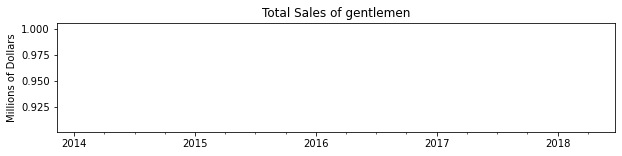

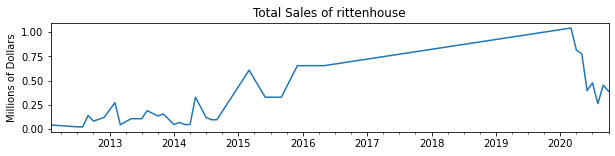

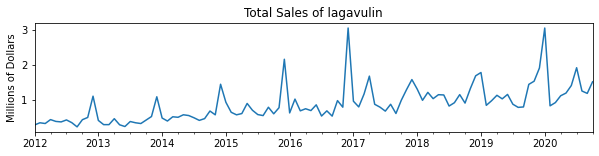

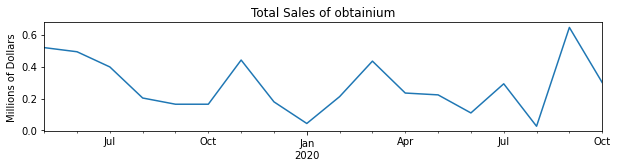

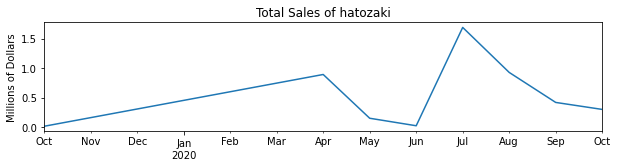

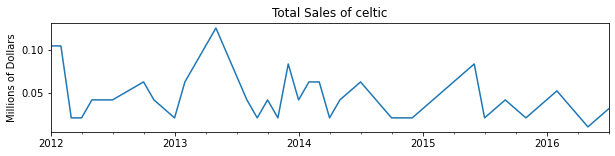

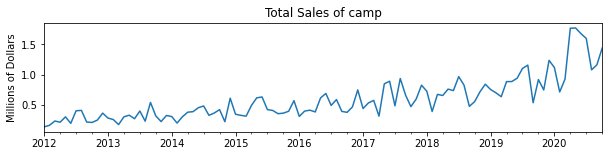

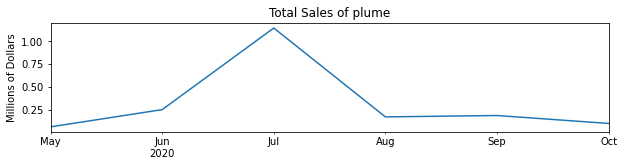

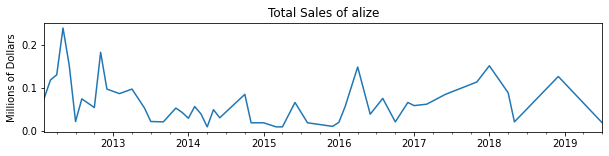

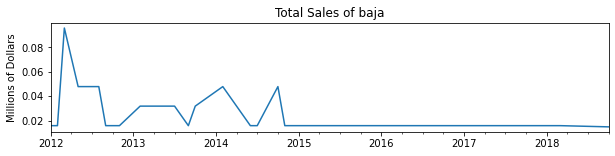

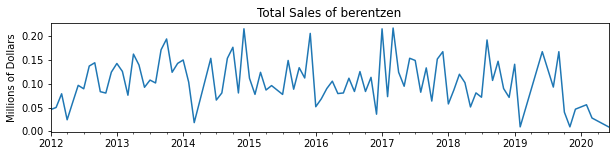

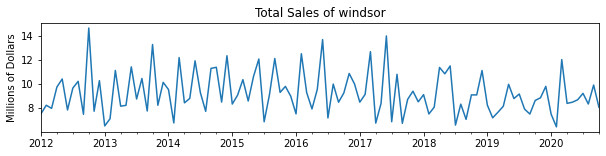

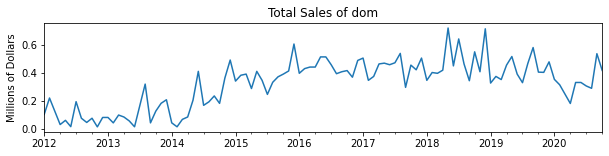

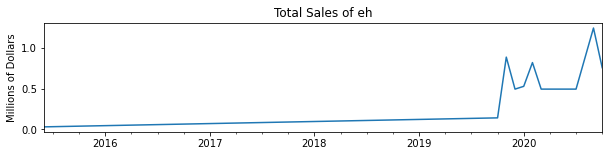

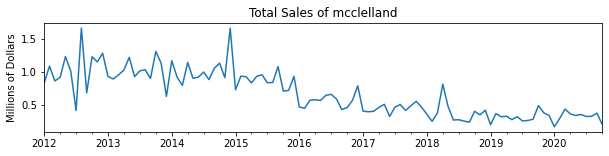

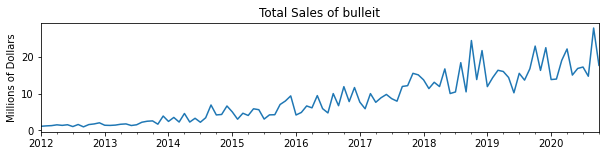

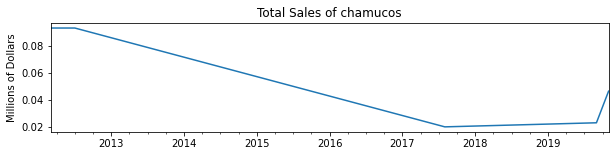

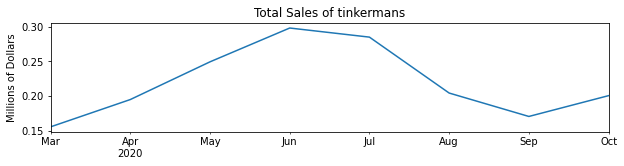

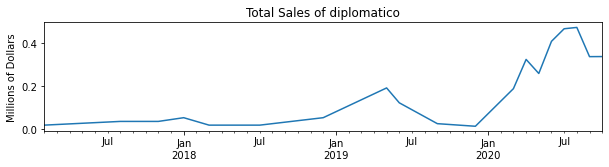

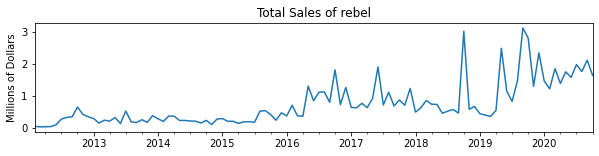

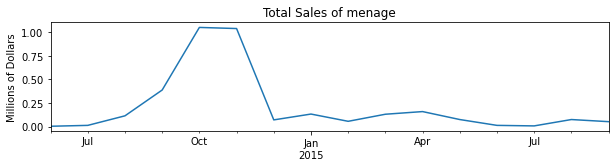

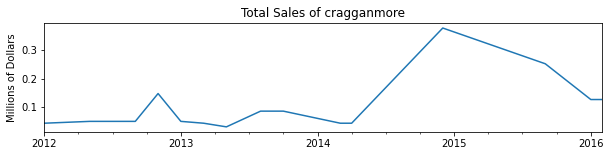

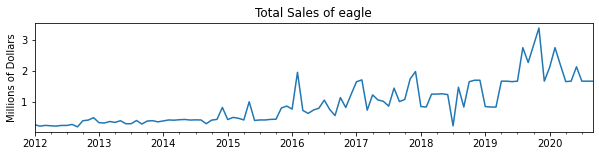

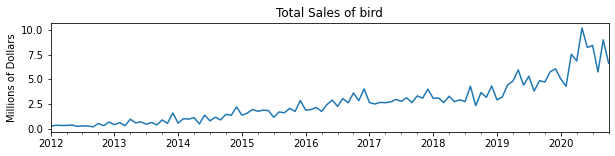

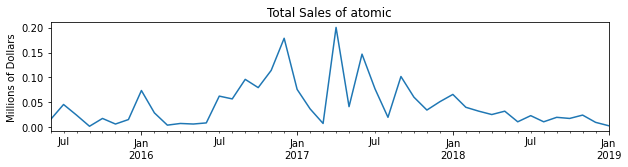

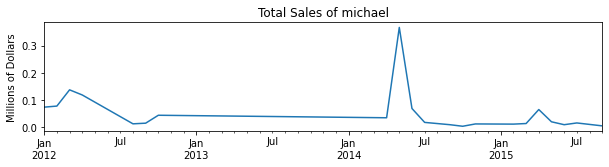

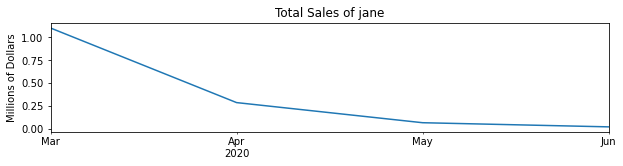

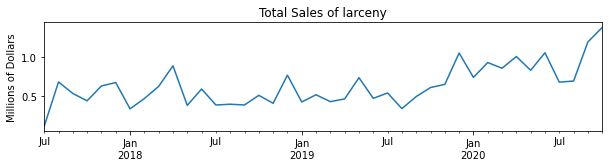

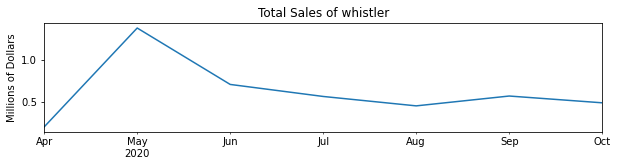

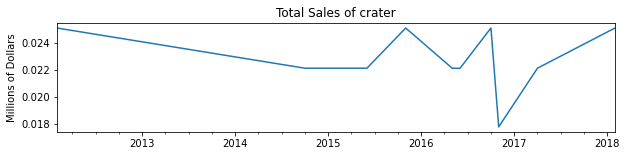

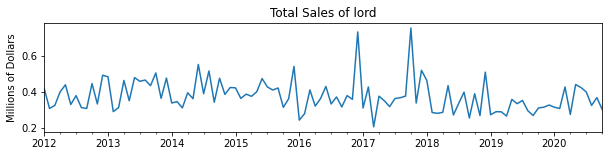

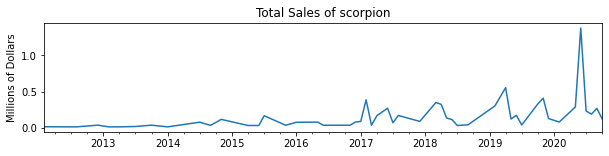

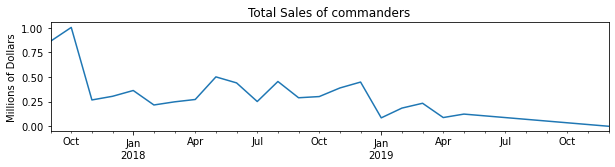

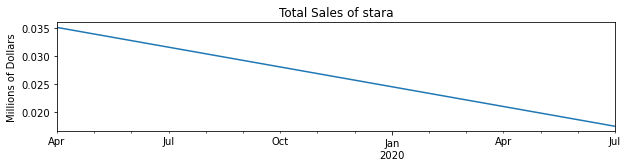

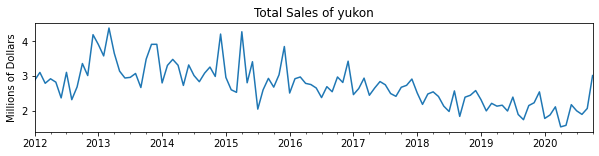

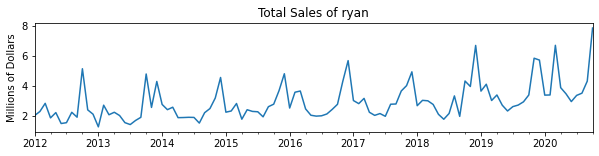

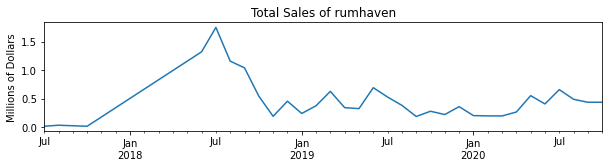

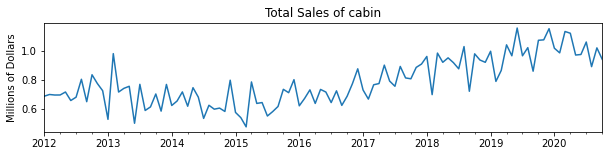

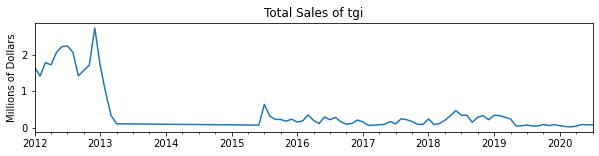

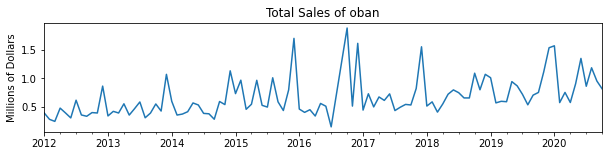

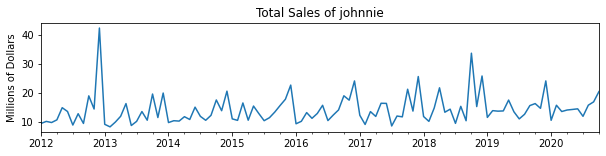

/Users/sunderland20a/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1136: UserWarning: Attempting to set identical left == right == 606.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


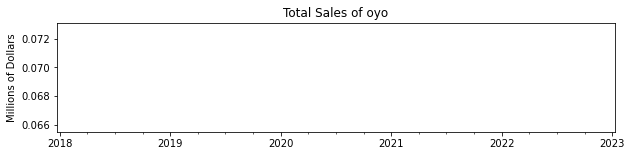

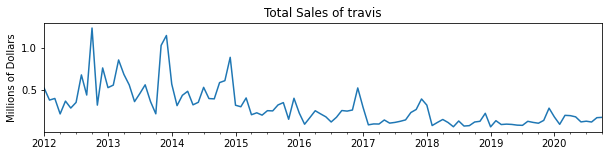

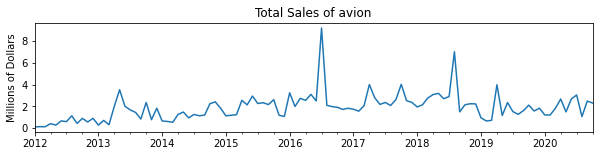

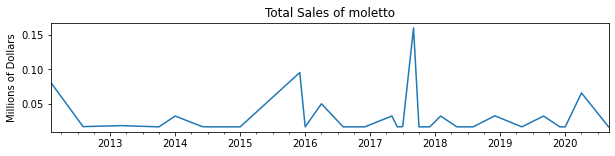

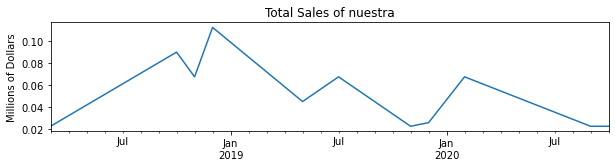

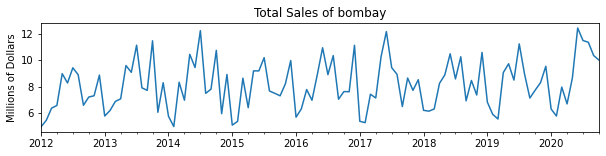

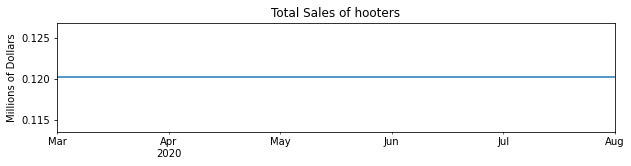

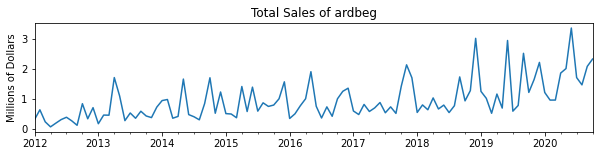

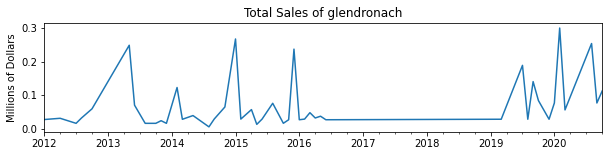

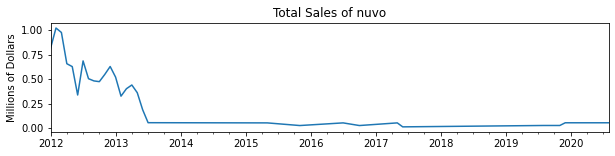

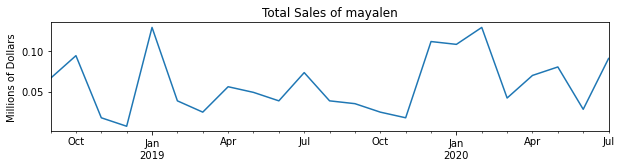

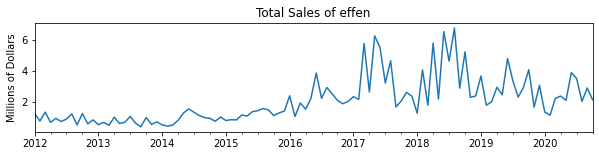

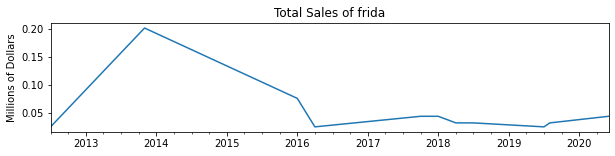

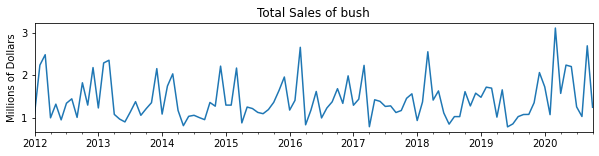

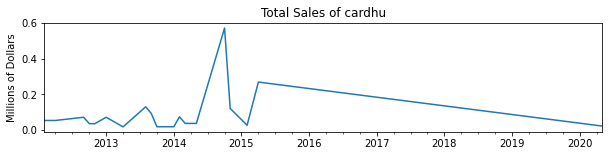

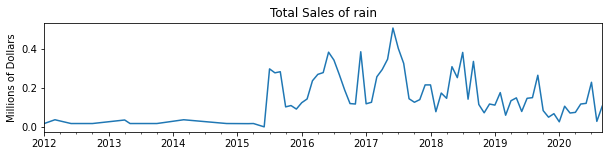

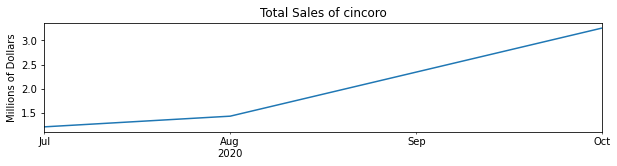

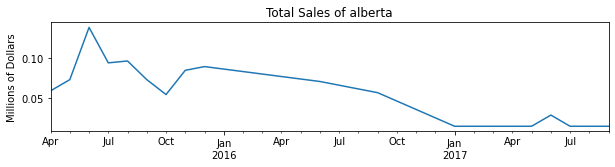

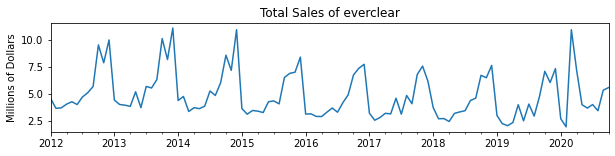

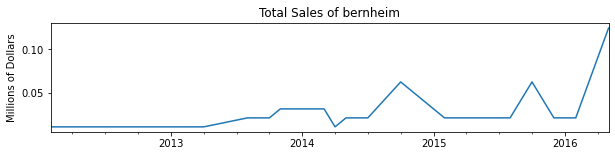

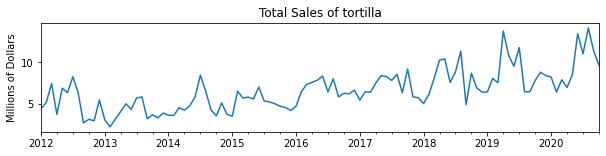

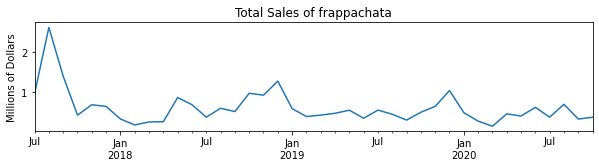

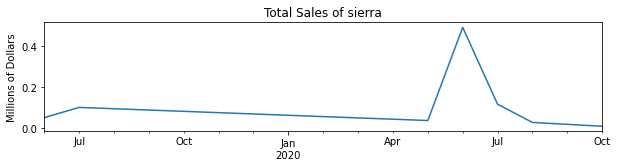

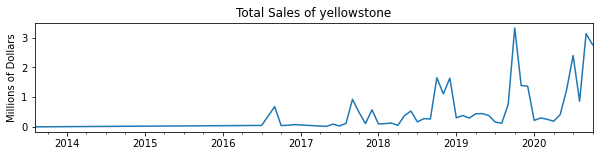

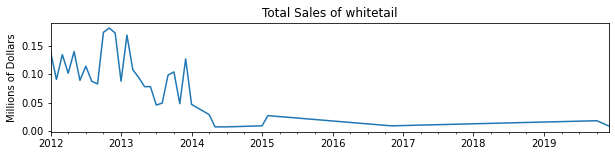

/Users/sunderland20a/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1136: UserWarning: Attempting to set identical left == right == 607.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


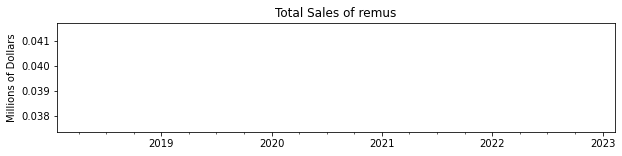

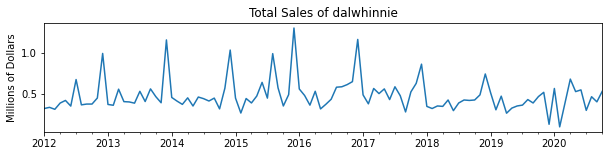

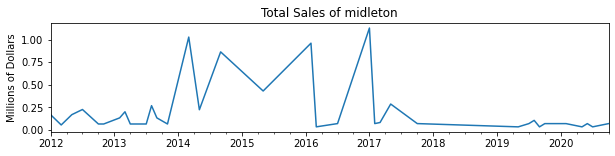

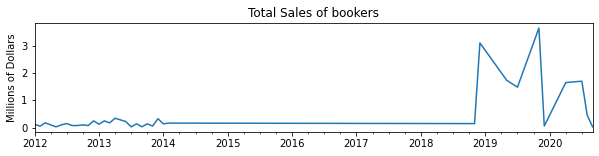

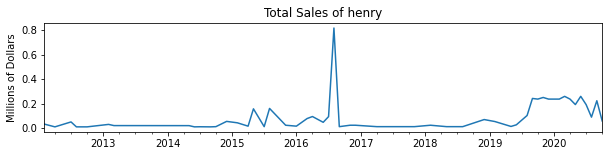

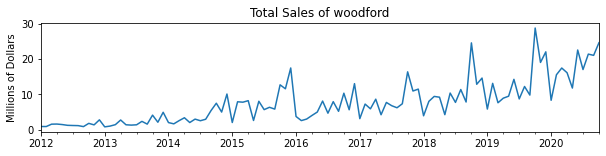

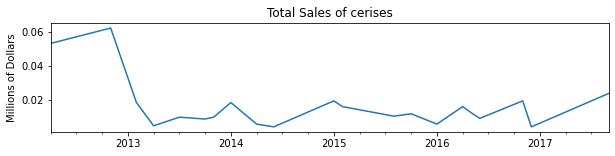

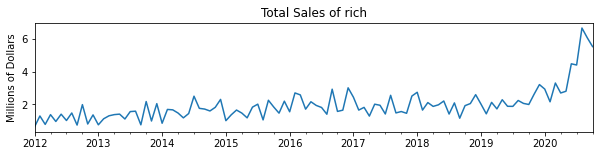

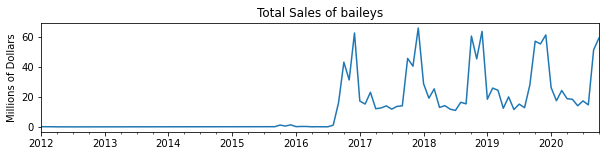

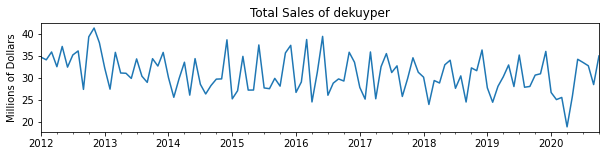

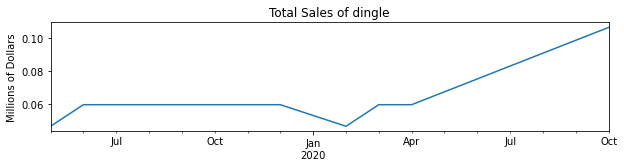

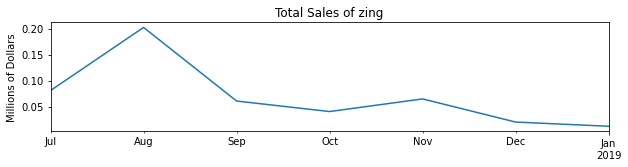

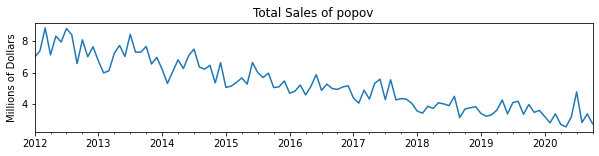

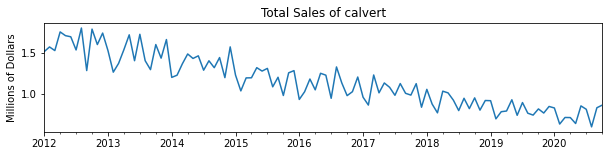

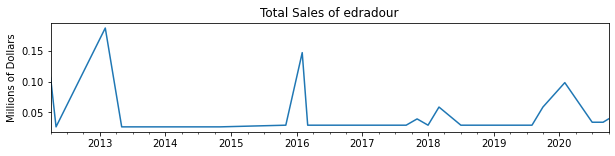

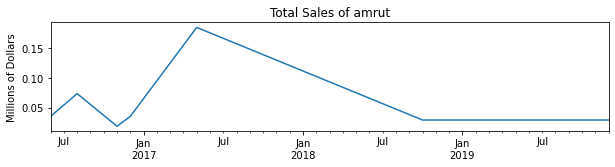

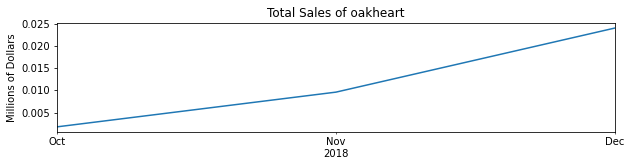

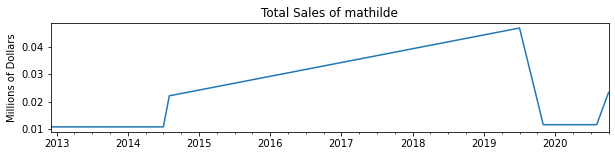

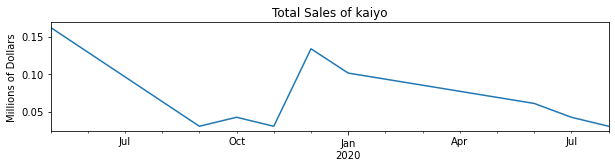

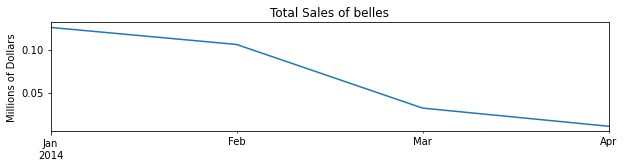

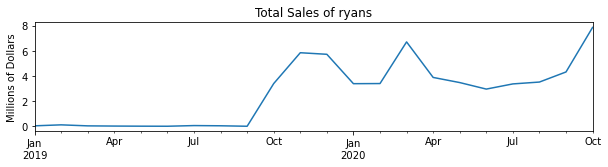

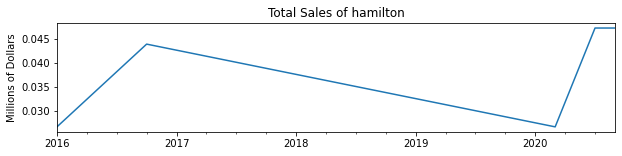

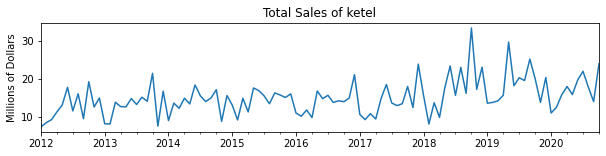

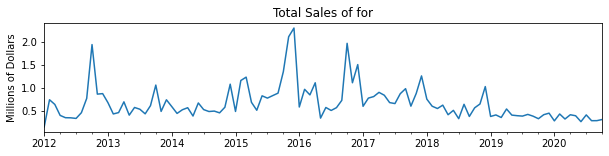

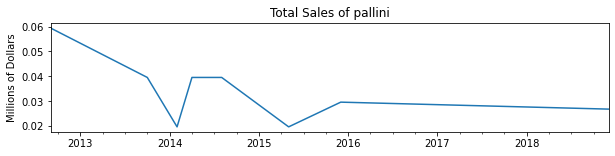

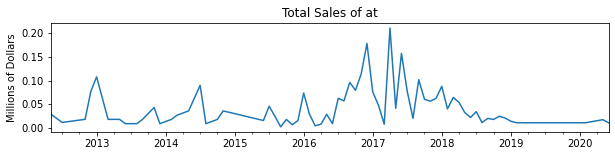

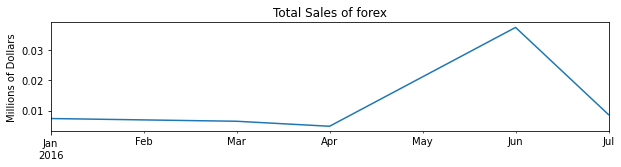

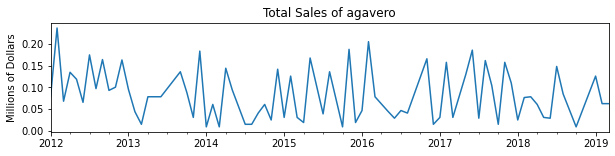

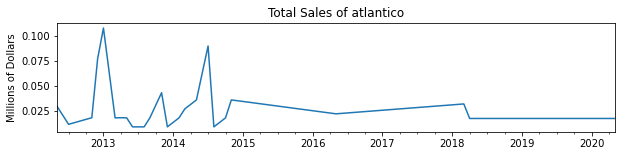

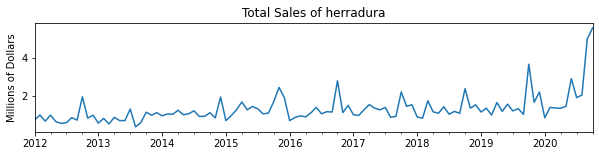

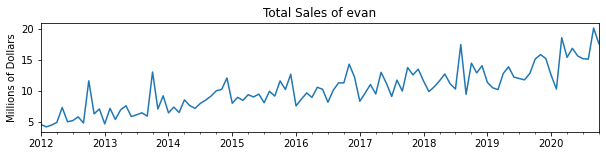

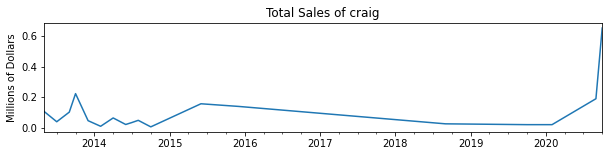

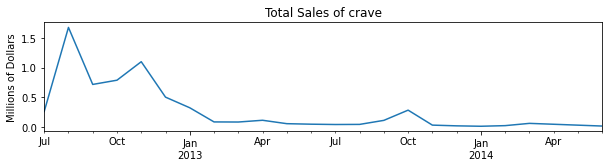

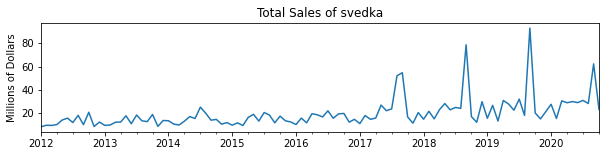

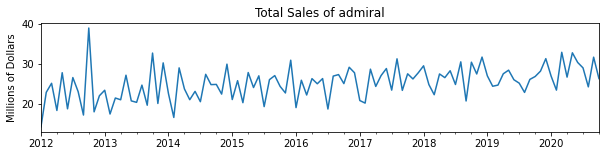

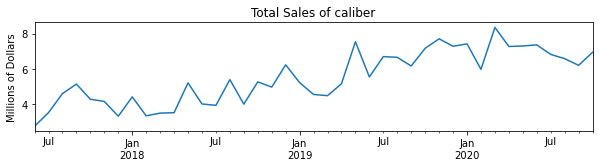

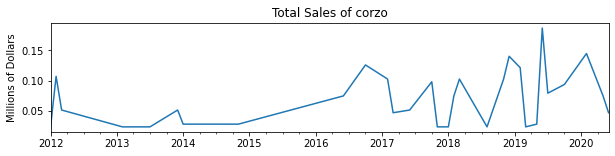

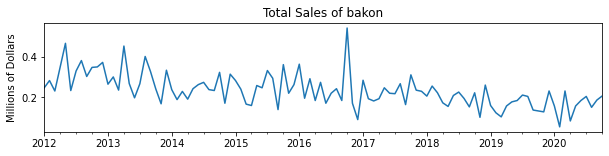

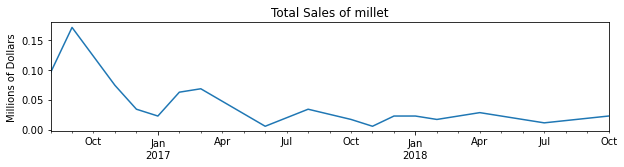

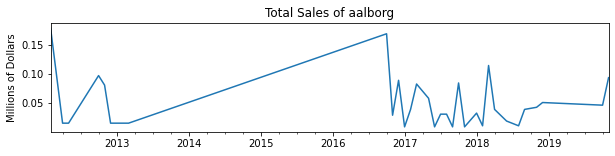

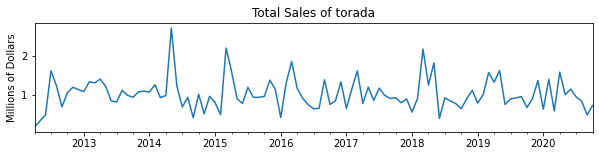

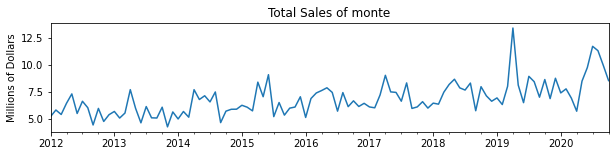

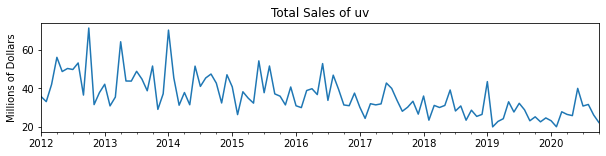

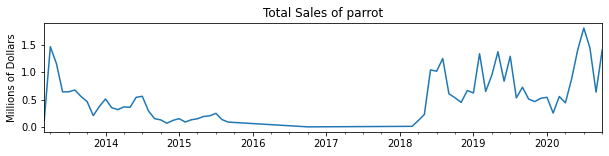

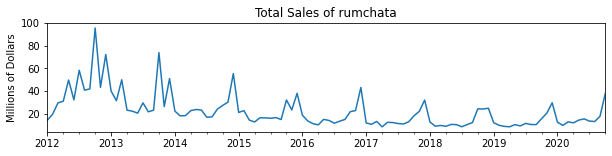

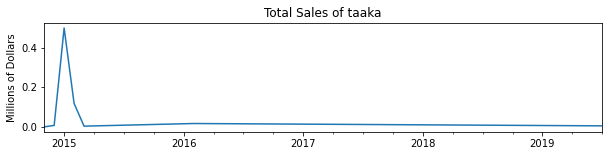

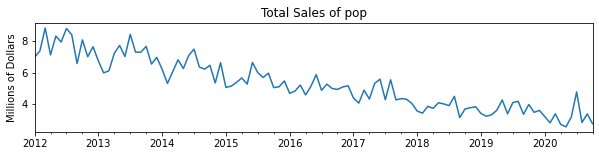

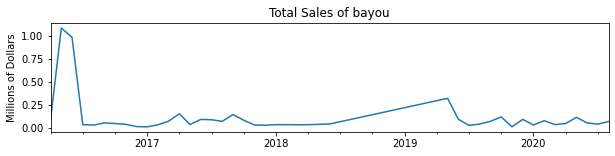

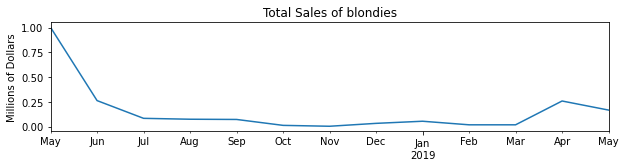

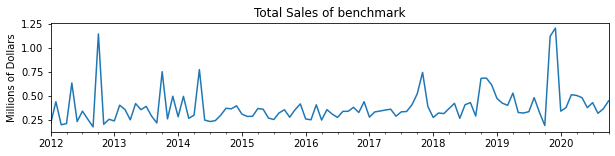

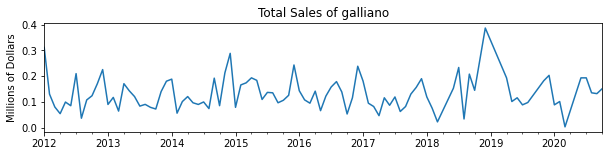

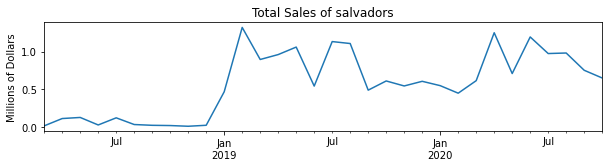

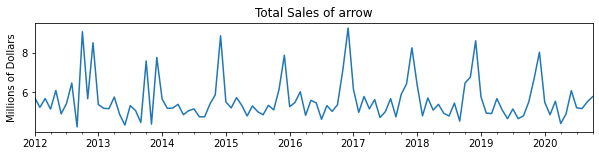

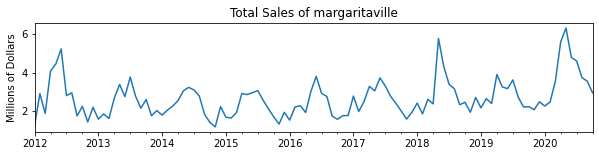

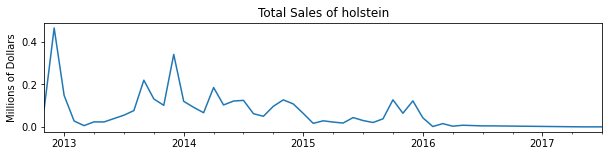

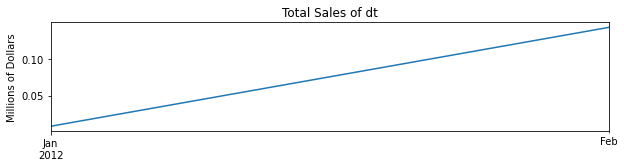

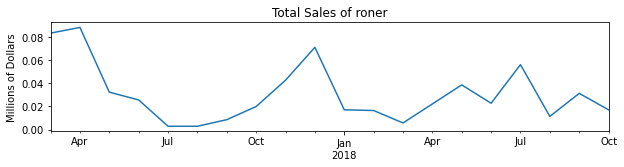

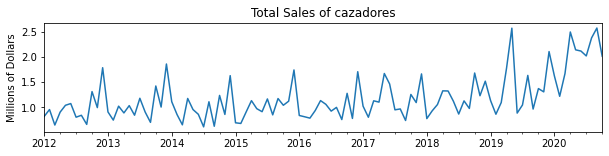

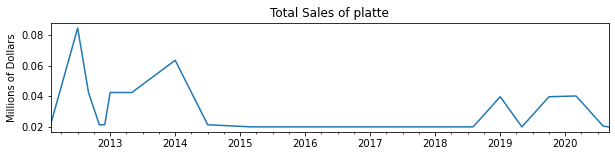

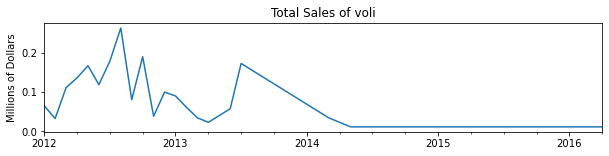

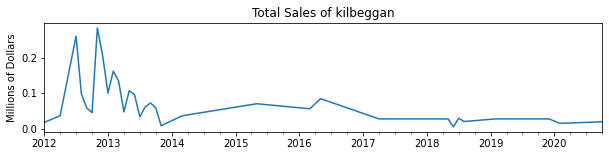

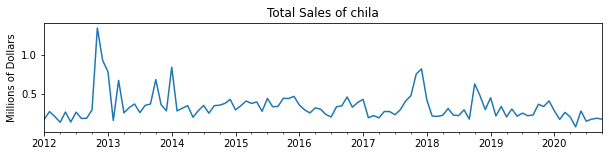

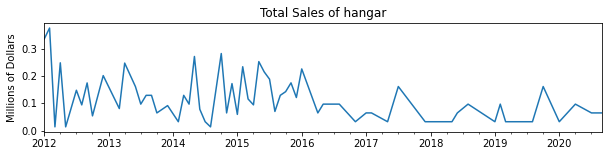

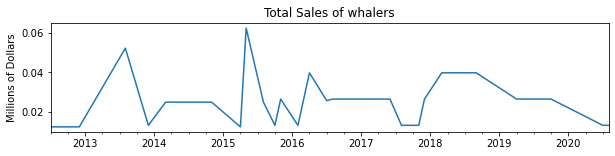

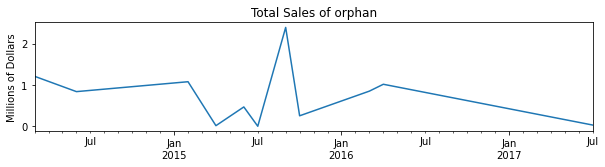

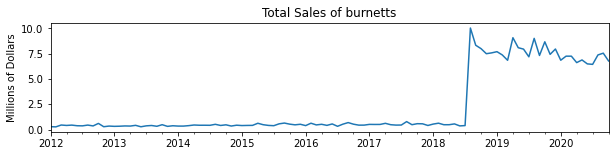

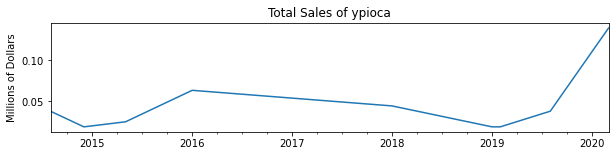

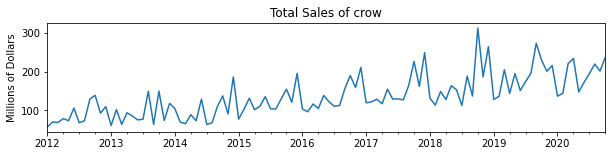

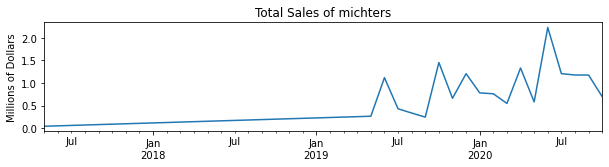

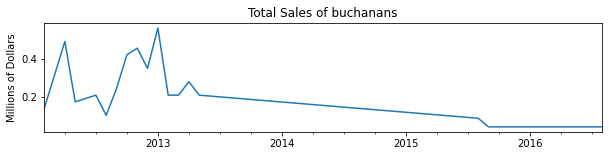

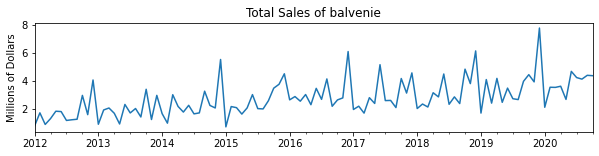

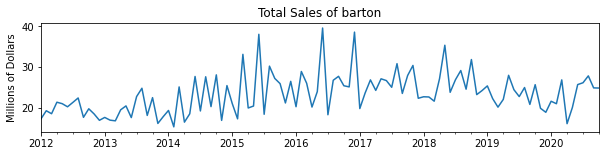

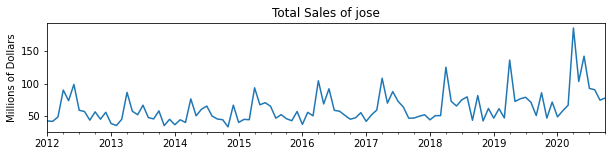

/Users/sunderland20a/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1136: UserWarning: Attempting to set identical left == right == 557.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


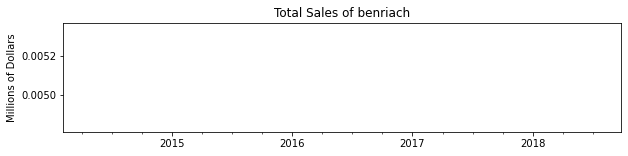

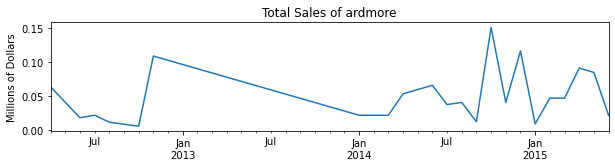

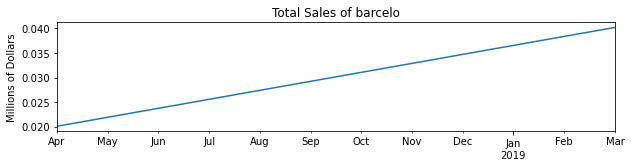

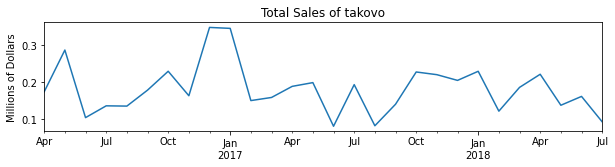

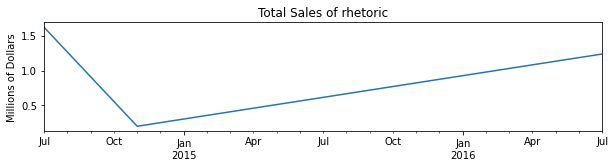

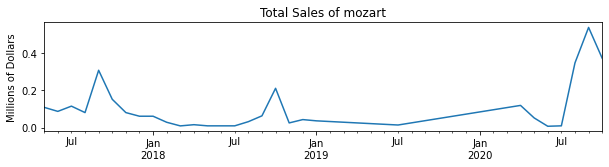

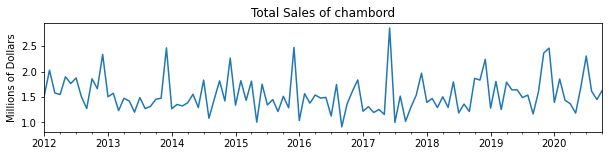

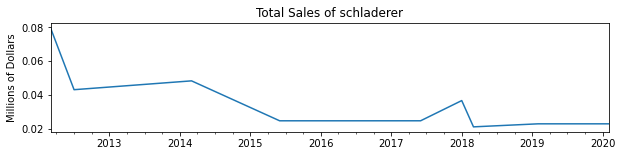

/Users/sunderland20a/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1136: UserWarning: Attempting to set identical left == right == 600.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


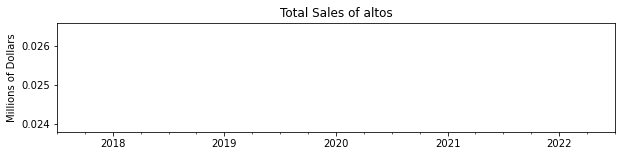

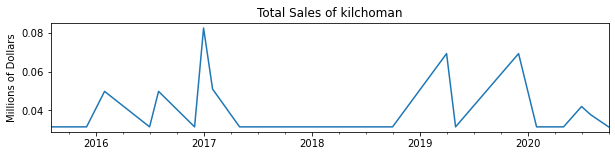

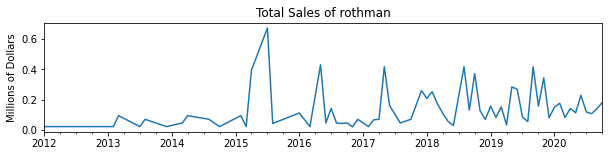

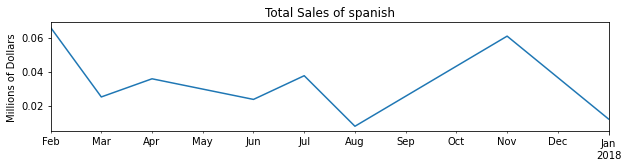

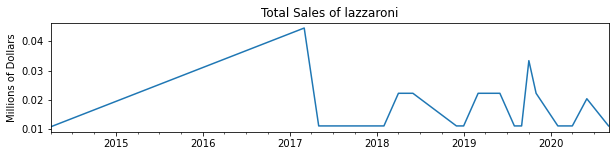

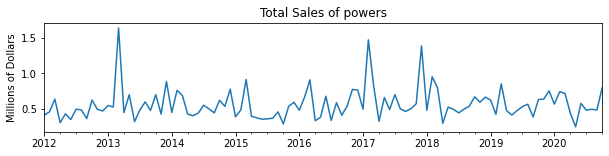

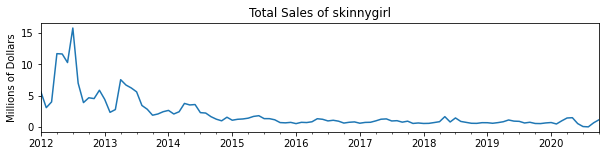

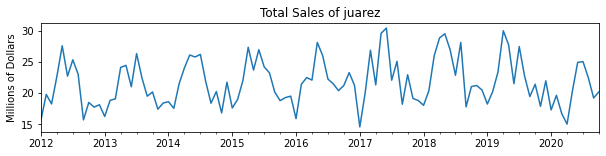

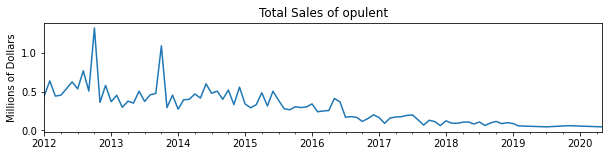

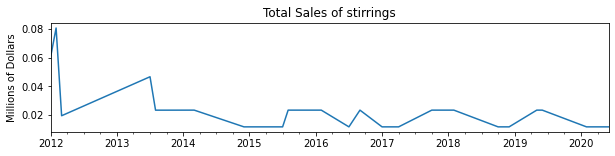

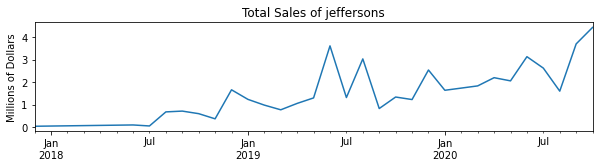

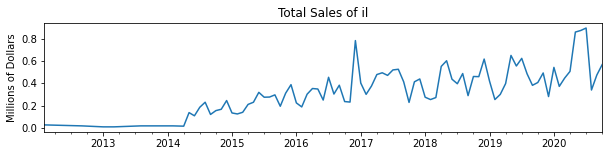

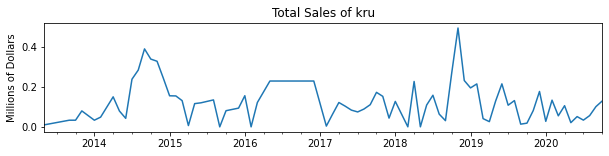

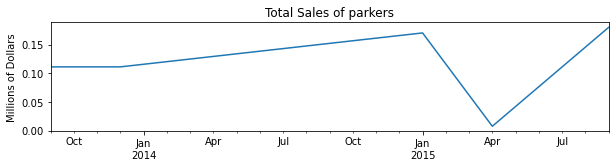

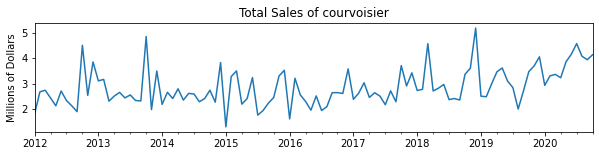

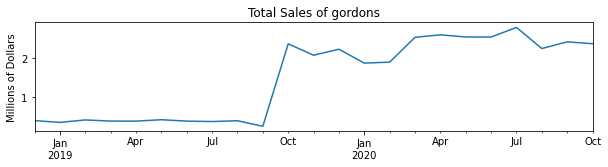

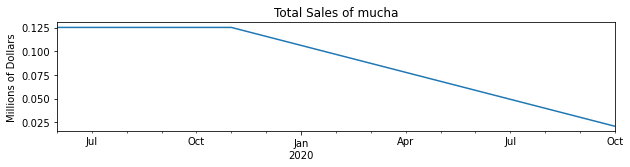

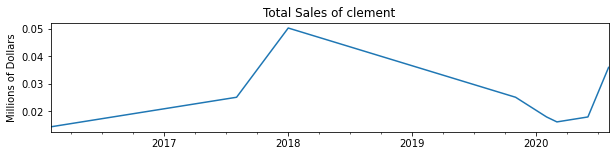

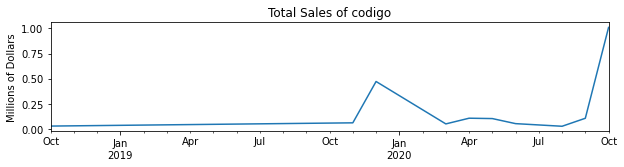

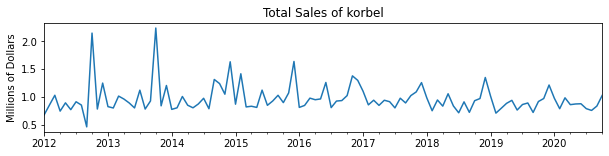

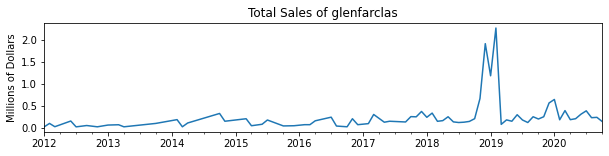

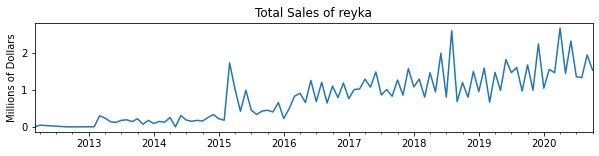

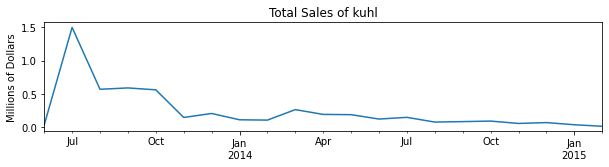

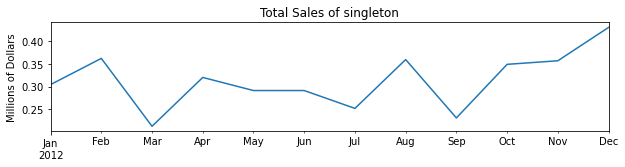

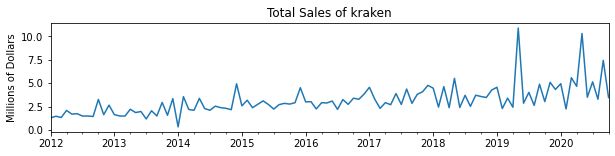

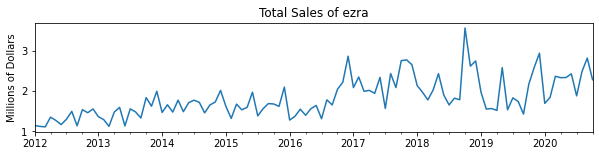

/Users/sunderland20a/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1136: UserWarning: Attempting to set identical left == right == 506.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


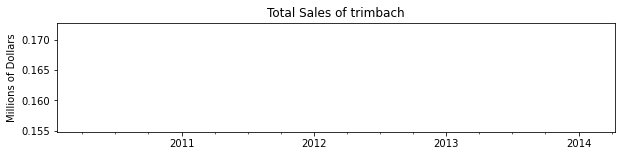

<IPython.core.display.Javascript object>

CPU times: user 1h 51min 40s, sys: 23min 10s, total: 2h 14min 50s
Wall time: 2h 38min 16s


In [8]:
%%time
%%notify

len(lines)
for item in lines:
    try:
        plot_item(item)
    except TypeError:
        pass

- Engineer the Lines column and redo this using that
- Include print out list of items that includes